In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import ks_2samp


from src.utils import plotting
from src.utils import tools

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri


from skbio.diversity import alpha_diversity
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_ind

In [2]:
FONT = 'JetBrains Mono'
FONTSNS =  'DejaVu Sans'

In [3]:
DATADIR = os.path.join(pathlib.Path().absolute(), 'data/')
RESULTSDIR = os.path.join(pathlib.Path().absolute(), 'results/')
PROCESSEDDIR = os.path.join(RESULTSDIR, 'processed_data/')
PLOTSDIR = os.path.join(pathlib.Path().absolute(), RESULTSDIR+'plots/')
MODELSDIR = os.path.join(RESULTSDIR, 'models/')

In [4]:
for directory in [DATADIR, RESULTSDIR, PROCESSEDDIR, PLOTSDIR, MODELSDIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Load metadata and read files

In [5]:
metadata = pd.read_excel(DATADIR+'metadata.xlsx')
metadata.rename(columns={'SAMPLE_ID': 'sample_id'}, inplace=True)
metadata['sample_id'] = metadata['sample_id'].astype(str)

metadata['AB_TITER'] = metadata['AB_TITER'].astype(str).str.replace('>400', '400') \
                        .str.replace(',', '.').str.replace('<', '').str.replace('V2 ', '').astype(float)


# replace all values in metadata that are '_' with NaN
metadata = metadata.replace('-', float('nan'))

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_72667/2041211267.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata = metadata.replace('-', float('nan'))


In [6]:
data = pd.read_csv(PROCESSEDDIR + 'preprocessed_data.csv', index_col=0, low_memory=False)
data['length'] = data['junction_aa'].str.len()
data['clonotype'] = data['v_call'] + '_' + data['junction_aa'] + '_' + data['j_call'] 
data = data.groupby(['clonotype', 'sample_id', 'SAMPLE', 'TIMEPOINTS',
                    'CONDITION', 'TCR_Chain','v_call','j_call','junction_aa'],
                    as_index=False).agg({'cloneFraction': 'sum', 'cloneCount': 'sum'})                                                                                                 
data.reset_index(drop=True, inplace=True)

In [7]:
data['clonotype'].nunique()

5294164

In [8]:
# Outlier to remove
data.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')

,clonotype,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,v_call,j_call,junction_aa,cloneFraction,cloneCount
4380708,TRBV15_CATSLANTGELFF_TRBJ2-2,4L,s_9,baseline,Lymphomas,TRB,TRBV15,TRBJ2-2,CATSLANTGELFF,0.020574,77251.0
4380709,TRBV15_CATSLANTGELFF_TRBJ2-2,5L,s_9,V1,Lymphomas,TRB,TRBV15,TRBJ2-2,CATSLANTGELFF,0.019033,80502.0
4380710,TRBV15_CATSLANTGELFF_TRBJ2-2,6L,s_9,V3,Lymphomas,TRB,TRBV15,TRBJ2-2,CATSLANTGELFF,0.017588,77318.0


In [9]:
# Remove false positive clonotype
rows_to_remove = data.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
data = data[~data.isin(rows_to_remove)].dropna()

In [10]:
DETECT_predictions = pd.read_csv(PROCESSEDDIR + 'DETECT_predictions.tsv', sep = '\t', low_memory=False)
DETECT_predictions.head()

,junction_aa,v_call,j_call,Epitope,Score,Reference TCRs,Antigen,Species
0,CAVRPQGGSEKLVF,TRAV21,TRAJ57,YPSVWRSSL,0.990449,"[('CAVRPQGGSEKLVF', '10.1101/2023.05.10.540189...",Ring finger protein 43 (RNF43),Homo sapiens
1,CAAQKTSYDKVIF,TRAV13-1,TRAJ50,VPWVWRSSL,0.976445,"[('CAAQKTSYDKVIF', '10.1101/2023.05.10.540189'...",Ring finger protein 43 (RNF43),Homo sapiens
2,CAYRSAGNQGAQKLVF,TRAV38-2/DV8,TRAJ54,YPSVWRSSL,0.971368,"[('CAYRSAGNQGAQKLVF', '10.1101/2023.05.10.5401...",Ring finger protein 43 (RNF43),Homo sapiens
3,CASTTGDEQFF,TRBV25-1,TRBJ2-1,CRVLCCYVL,0.857744,"[('CASTTGDEQFF', '10.4049/jimmunol.1801401')]",Trans-activating transcriptional regulatory pr...,Human betaherpesvirus 5
4,CVVNNQDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.855679,"[('CVVNNQDDMRF', '10.1016/j.immuni.2020.11.004')]",Spike/surface glycoprotein (S),SARS-CoV-2


## Load DETECT predictions

In [11]:
DETECT_predictions = pd.read_csv(PROCESSEDDIR + 'DETECT_predictions.tsv', sep = '\t', low_memory=False)
# filter only SARS-CoV-2 Spike protein, we could choose a higher score threshold here to further remove false positives
DETECT_predictions = DETECT_predictions.query('Score >= 0.2 and Antigen == "Spike/surface glycoprotein (S)" and Species == "SARS-CoV-2"')
DETECT_predictions.reset_index(drop=True, inplace=True)
DETECT_predictions.rename(columns={'Epitope': 'epitope'}, inplace=True)
DETECT_predictions['clonotype'] = DETECT_predictions['v_call'] + '_' + DETECT_predictions['junction_aa'] + '_' + DETECT_predictions['j_call'] 
DETECT_predictions.drop_duplicates(subset=['clonotype'],inplace=True)

In [12]:
DETECT_predictions.head()

,junction_aa,v_call,j_call,epitope,Score,Reference TCRs,Antigen,Species,clonotype
0,CVVNNQDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.855679,"[('CVVNNQDDMRF', '10.1016/j.immuni.2020.11.004')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNNQDDMRF_TRAJ43
1,CVVNDADKLIF,TRAV12-1,TRAJ34,YLQPRTFLL,0.854991,"[('CVVNDADKLIF', '10.1016/j.cell.2022.07.002')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNDADKLIF_TRAJ34
2,CVVNNLDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.840085,"[('CVVNNLDDMRF', '10.1016/j.immuni.2020.11.004')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNNLDDMRF_TRAJ43
3,CVVNTLDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.812081,"[('CVVNTLDDMRF', '10.1016/j.immuni.2020.11.004')]",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNTLDDMRF_TRAJ43
4,CVVNRRDDMRF,TRAV12-1,TRAJ43,YLQPRTFLL,0.770238,"[('CVVNRRDDMRF', '10.1016/j.immuni.2020.11.004...",Spike/surface glycoprotein (S),SARS-CoV-2,TRAV12-1_CVVNRRDDMRF_TRAJ43


In [13]:
uniques = pd.DataFrame({'countUniqueCDR3': data.query('TCR_Chain == "TRA" or TCR_Chain == "TRB"').groupby(['sample_id', 'TCR_Chain'])['clonotype'].nunique()}).reset_index()
uniques = pd.merge(uniques, metadata, on = 'sample_id', how='left')

# group by sample_id and sum cloneCount
library_size = data.groupby(['sample_id','TCR_Chain']).agg({'cloneCount': 'sum'}).reset_index()
uniques = pd.merge(uniques, library_size, on = ['sample_id', 'TCR_Chain'], how='left')
uniques['normalizedUniqueCDR3'] = uniques['countUniqueCDR3'] / uniques['cloneCount']

### Proportion of TCR sequences that recognize different virus antigens in COVID-19 patients 

In [14]:
uniques_other = pd.DataFrame({'countUniqueClonotypes': data.groupby(['sample_id'])['clonotype'].nunique()}).reset_index()
uniques_other = pd.merge(uniques_other, metadata, on = 'sample_id', how='left')
uniques_other

,sample_id,countUniqueClonotypes,CODICE,CONDITION,TIMEPOINTS,SAMPLE,SEX,AGE,AB_TITER,Tipo di linfoma,Grado,Stadio,Data di morte,Data di progressione di malattia,Trattamento al momento della vaccinazione,Tipo di mutazione
0,10L,45495,676.0,Lymphomas,baseline,s_11,F,80,3.8,LNH,NaN,4,45108.0,44883.0,Non in trattamento alla vaccinazione prima rit...,NaN
1,11L,121149,NaN,Lymphomas,V1,s_11,F,80,5.1,LNH,NaN,4,45108.0,44883.0,Non in trattamento alla vaccinazione prima rit...,NaN
2,12L,256083,NaN,Lymphomas,V3,s_11,F,80,3.8,LNH,NaN,4,45108.0,44883.0,Non in trattamento alla vaccinazione prima rit...,NaN
3,13L,243979,674.0,Lymphomas,baseline,s_12,F,68,3.8,LNH,G3A,NaN,NaN,NaN,rituximab,Positivo il riarrangiamento con IgH
4,14L,477076,NaN,Lymphomas,V1,s_12,F,68,3.8,LNH,G3A,NaN,NaN,NaN,rituximab,Positivo il riarrangiamento con IgH
5,15L,231744,NaN,Lymphomas,V3,s_12,F,68,3.8,LNH,G3A,NaN,NaN,NaN,rituximab,Positivo il riarrangiamento con IgH
6,16L,19240,678.0,Lymphomas,baseline,s_13,F,55,3.8,LNH,NaN,NaN,NaN,NaN,R-bendamustin prima nel 2020,NaN
7,17L,34860,NaN,Lymphomas,V1,s_13,F,55,3.8,LNH,NaN,NaN,NaN,NaN,R-bendamustin prima nel 2020,NaN
8,18L,25507,NaN,Lymphomas,V3,s_13,F,55,3.8,LNH,NaN,NaN,NaN,NaN,R-bendamustin prima nel 2020,NaN
9,19L,11651,683.0,Lymphomas,baseline,s_14,F,75,3.8,LNH (DLBCL),NaN,4,NaN,NaN,R-COMP prima del vaccino,NaN


In [15]:
DETECT_predictions_other_viruses = pd.read_csv(PROCESSEDDIR + 'DETECT_predictions.tsv', sep = '\t', low_memory=False)
# filter only SARS-CoV-2 Spike protein, we could choose a higher score threshold here to further remove false positives
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses.query('Score >= 0.2 and Species != "SARS-CoV-2"')
DETECT_predictions_other_viruses.reset_index(drop=True, inplace=True)
DETECT_predictions_other_viruses.rename(columns={'Epitope': 'epitope'}, inplace=True)
DETECT_predictions_other_viruses['clonotype'] = DETECT_predictions_other_viruses['v_call'] + '_' + DETECT_predictions_other_viruses['junction_aa'] + '_' + DETECT_predictions_other_viruses['j_call'] 
DETECT_predictions_other_viruses['TCR_Chain'] = DETECT_predictions_other_viruses['v_call'].str[:3]
DETECT_predictions_other_viruses.drop_duplicates(subset=['clonotype'],inplace=True)
DETECT_predictions_other_viruses

,junction_aa,v_call,j_call,epitope,Score,Reference TCRs,Antigen,Species,clonotype,TCR_Chain
0,CAVRPQGGSEKLVF,TRAV21,TRAJ57,YPSVWRSSL,0.990449,"[('CAVRPQGGSEKLVF', '10.1101/2023.05.10.540189...",Ring finger protein 43 (RNF43),Homo sapiens,TRAV21_CAVRPQGGSEKLVF_TRAJ57,TRA
1,CAAQKTSYDKVIF,TRAV13-1,TRAJ50,VPWVWRSSL,0.976445,"[('CAAQKTSYDKVIF', '10.1101/2023.05.10.540189'...",Ring finger protein 43 (RNF43),Homo sapiens,TRAV13-1_CAAQKTSYDKVIF_TRAJ50,TRA
2,CAYRSAGNQGAQKLVF,TRAV38-2/DV8,TRAJ54,YPSVWRSSL,0.971368,"[('CAYRSAGNQGAQKLVF', '10.1101/2023.05.10.5401...",Ring finger protein 43 (RNF43),Homo sapiens,TRAV38-2/DV8_CAYRSAGNQGAQKLVF_TRAJ54,TRA
3,CASTTGDEQFF,TRBV25-1,TRBJ2-1,CRVLCCYVL,0.857744,"[('CASTTGDEQFF', '10.4049/jimmunol.1801401')]",Trans-activating transcriptional regulatory pr...,Human betaherpesvirus 5,TRBV25-1_CASTTGDEQFF_TRBJ2-1,TRB
4,CVVSSNKLIF,TRAV12-1,TRAJ4,VVMSWAPPV,0.838318,"[('CVVSSNKLIF', '10.1038/s41590-021-01073-2'),...",Fibronectin type III domain-containing protein...,Synthetic,TRAV12-1_CVVSSNKLIF_TRAJ4,TRA
...,...,...,...,...,...,...,...,...,...,...
50401,CASSFRHTDTQYF,TRBV7-2,TRBJ2-3,PQPELPYPQPE,0.200001,"[('CASSFRNTDTQYF', '10.1093/intimm-dxt037'), (...",Gliadin,Triticum aestivum,TRBV7-2_CASSFRHTDTQYF_TRBJ2-3,TRB
50402,CAAKSENAGNMLTF,TRAV13-1,TRAJ39,ELAGIGILTV,0.200000,"[('CAAKSENAGNMLTF', '10.1038/s41590-021-01073-...",Melanoma antigen recognized by T-cells 1 (MART...,"Homo sapiens,Synthetic",TRAV13-1_CAAKSENAGNMLTF_TRAJ39,TRA
50403,CAERQNFVF,TRAV13-2,TRAJ26,GILGFVFTL,0.200000,"[('CAERQNFVF', '10.1126/sciadv.abf5835')]",Matrix protein 1 (M),Influenza A virus,TRAV13-2_CAERQNFVF_TRAJ26,TRA
50404,CAVAGAGGYQKVTF,TRAV12-2,TRAJ13,ELAGIGILTV,0.200000,"[('CAVAGAGGYQKVTF', '10.1038/s41590-021-01073-...",Melanoma antigen recognized by T-cells 1 (MART...,"Homo sapiens,Synthetic",TRAV12-2_CAVAGAGGYQKVTF_TRAJ13,TRA


In [16]:
print(DETECT_predictions_other_viruses['Species'].unique())
# remove those rows that have Home sapiens in Species
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses.query('Species != "SARS-CoV-2,SARS-CoV"')
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses.query('Species != "Homo sapiens"')
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses.query('Species != "Synthetic"')
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses.query('Species != "Hepatitis C virus,Synthetic"')
DETECT_predictions_other_viruses = DETECT_predictions_other_viruses.query('Species != "Homo sapiens,Synthetic"')

['Homo sapiens' 'Human betaherpesvirus 5' 'Synthetic'
 'Hepatitis C virus,Synthetic' 'Homo sapiens,Synthetic' 'HIV'
 'Yellow fever virus' 'Human gammaherpesvirus 4' 'Hepatitis C virus' 'HPV'
 'HIV,HIV-1' 'Influenza A virus' 'Mycobacterium' 'SARS-CoV-2,SARS-CoV'
 'Influenza B virus' 'Hepatitis B virus'
 'Influenza A virus,Influenza B virus' 'HTLV-1,Homo sapiens' 'Bacteria'
 'Triticum aestivum' 'Human mastadenovirus C' 'Dengue Virus 1' 'HTLV-1'
 'Chrysanthemum virus B' 'Human alphaherpesvirus 2' 'HIV-1,HIV'
 'Rotavirus' 'Plasmodium falciparum' 'Pseudomonas aeruginosa'
 'Dengue Virus 3,Dengue Virus 4' 'Human alphaherpesvirus 1']


In [17]:
other_virus_data = pd.merge(data[['clonotype','sample_id','SAMPLE','TIMEPOINTS','CONDITION']], DETECT_predictions_other_viruses.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['clonotype','Score','epitope', 'Antigen', 'Species']], on = ['clonotype'], how='left', indicator=True).query('_merge == "both"')
other_virus_data['NClonotypes_detected'] = 1
other_virus_data = other_virus_data.groupby(['sample_id','SAMPLE','TIMEPOINTS','CONDITION']).agg({'NClonotypes_detected': 'sum'}).reset_index()
other_virus_data

,sample_id,SAMPLE,TIMEPOINTS,CONDITION,NClonotypes_detected
0,10L,s_11,baseline,Lymphomas,497
1,11L,s_11,V1,Lymphomas,1114
2,12L,s_11,V3,Lymphomas,2389
3,13L,s_12,baseline,Lymphomas,2278
4,14L,s_12,V1,Lymphomas,4075
5,15L,s_12,V3,Lymphomas,1898
6,16L,s_13,baseline,Lymphomas,233
7,17L,s_13,V1,Lymphomas,377
8,18L,s_13,V3,Lymphomas,269
9,19L,s_14,baseline,Lymphomas,184


In [18]:
other_virus_data = pd.merge(uniques_other, other_virus_data)
other_virus_data['viral_ratio'] = other_virus_data['NClonotypes_detected']/other_virus_data['countUniqueClonotypes']
other_virus_data[['sample_id', 'countUniqueClonotypes', 'NClonotypes_detected', 'viral_ratio','CONDITION', 'TIMEPOINTS', 'SAMPLE']].to_csv(PROCESSEDDIR + 'other_viral_data.csv')

In [19]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Healthy", "Lymphomas"))

timepoint_colors = {
    "baseline": '#004D40',
    "V1": '#1E88E5',
    "V3": '#FFC107'
}

healthy_data = other_virus_data.query('CONDITION == "Healthy"')

for timepoint in healthy_data["TIMEPOINTS"].unique():
    filtered_data = healthy_data[healthy_data["TIMEPOINTS"] == timepoint]
    fig.add_trace(
        go.Bar(x=filtered_data["SAMPLE"], y=filtered_data["viral_ratio"],
            name=timepoint, #text=filtered_data["normalizedUniqueCDR3"], 
            marker=dict(color=timepoint_colors[timepoint], line=dict(width=0.5)),
            showlegend=True),
        row=1, col=1
    )
    
lymphomas_data = other_virus_data.query('CONDITION == "Lymphomas"')
for timepoint in lymphomas_data["TIMEPOINTS"].unique():
    filtered_data = lymphomas_data[lymphomas_data["TIMEPOINTS"] == timepoint]
    fig.add_trace(
        go.Bar(x=filtered_data["SAMPLE"], y=filtered_data["viral_ratio"],
            name=timepoint, #text=filtered_data["normalizedUniqueCDR3"],
            marker=dict(color=timepoint_colors[timepoint], line=dict(width=0.5)),
            showlegend=False),
        row=1, col=2
    )
    
    
    
# Update axis title for all subplots
fig.update_xaxes(title_text="Sample", row=1, col=1)
fig.update_xaxes(title_text="Sample", row=1, col=2)

fig.update_yaxes(title_text="Viral Ratio", row=1, col=1)
    
fig.update_traces(
    textfont_size=12, textangle=0, textposition="outside", cliponaxis=False, marker_line_width=2,
    
)
fig.update_layout(
    font=dict(family=FONT, size=12),
    #paper_bgcolor='rgb(243, 243, 243)',
    #plot_bgcolor='rgb(243, 243, 243)',
    barmode='group',
    bargap=0.1,
    title_text="Ratio of clonotypes predicted to be specific to other pathogens",
    xaxis_title="Sample",
    yaxis_title="Viral Ratio",
    legend_title="Timepoints",
    height = 600,
    width = 1200,
    template="plotly_white"
)
fig.update_yaxes(tickangle=45, tickmode='array', showgrid = False)
fig.update_xaxes(tickangle=45, showgrid=True)
fig.show()
fig.write_image(PLOTSDIR+"other_viral_barplot.png", scale = 4)

## HLA prediction data for HLA-Guessr

In [ ]:
hla_data = data.copy()

selected = [
    "junction_aa",
    "v_call",
    "SAMPLE",   
    "TCR_Chain" 
]
renamed = [
    "cdr3aa",
    "v_gene",
    "Patient",
    "TCR_Chain"
]

hla_data = hla_data[selected]
hla_data.columns = renamed
hla_data.drop_duplicates(inplace=True)
hla_data_beta = hla_data.query('TCR_Chain == "TRB"')
hla_data_alpha = hla_data.query('TCR_Chain == "TRA"')
hla_data_beta.drop(columns=['TCR_Chain'], inplace=True)
hla_data_alpha.drop(columns=['TCR_Chain'], inplace=True)

hla_data_alpha.to_csv('/Users/fabioaffaticati/Desktop/Work/HLA-guessr/alpha_chains/hla_data_alpha_lucia.tsv', sep='\t', index=False)
hla_data_beta.to_csv('/Users/fabioaffaticati/Desktop/Work/HLA-guessr/beta_chains/hla_data_beta_lucia.tsv', sep='\t', index=False)

## HLA prediction data for HLA3 (Koshlan Mayer-Blackwell)

In [122]:
hla3_data = data.copy()
hla3_data = hla3_data.query('TCR_Chain == "TRB"')

hla3_data = hla3_data.groupby(['clonotype', 'SAMPLE', 'v_call','j_call','junction_aa'],
                    as_index=False).agg({'cloneFraction': 'sum', 'cloneCount': 'sum'}) 
hla3_data['v_call'] = hla3_data['v_call'] + '*01'
hla3_data['j_call'] = hla3_data['j_call'] + '*01'

selected = [
    "junction_aa",
    "v_call",
    "j_call",
    "SAMPLE",   
    "cloneCount",
    "cloneFraction"
]
renamed = [
    "cdr3_b_aa",
    "v_b_gene",
    "j_b_gene",
    "subject",
    "count",
    "productive_frequency"
]

hla3_data = hla3_data[selected]
hla3_data.columns = renamed

for patient in hla3_data['subject'].unique():
    patient_data = hla3_data.query('subject == @patient')
    patient_data['sum_productive_templates_calc'] = patient_data['count'].sum()
    patient_data.to_csv( ( os.path.join("/Users/fabioaffaticati/Desktop/Work/HLA3/hla3-main/input_data/lucia_data/",
                                    patient+'.hla3_data.tsv') ), sep='\t', index=False)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_26596/614392596.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data['sum_productive_templates_calc'] = patient_data['count'].sum()
/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_26596/614392596.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data['sum_productive_templates_calc'] = patient_data['count'].sum()
/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_26596/614392596.py:31: SettingWithCopyWarning

## Load and combine HLA predictions

In [20]:
hla3_predictions = pd.read_csv(PROCESSEDDIR + 'hla3_predictions.tsv', sep='\t')[['sample', 'hla_1', 'hla_2', 'locus']]
hla_guessr_predictions = pd.read_csv(PROCESSEDDIR + 'HLA-Guessr_predictions.tsv', sep='\t')[['Individual_ID', 'hla_1', 'hla_2', 'locus']]

renamed = [
    "sample",
    "guessr_hla_1",
    "guessr_hla_2",
    'locus'
]
hla_guessr_predictions.columns = renamed


In [21]:
combined_predictions = pd.merge(hla3_predictions, hla_guessr_predictions, on=['sample','locus'],how='outer')

# for each row, if there is a match between hla_1 and guessr_hla_1 or guessr_hla_2 put the value in the column match
combined_predictions['match'] = np.nan

for i, row in combined_predictions.iterrows():
    if row['hla_1'] == row['guessr_hla_1'] or row['hla_1'] == row['guessr_hla_2']:
        combined_predictions.loc[i,'match']= str(row['hla_1'])
    elif (row['hla_2'] == row['guessr_hla_1']) or row['hla_2'] == row['guessr_hla_2']:
        combined_predictions.loc[i,'match']= str(row['hla_2'])
    else:
        combined_predictions.loc[i,'match']= str(row['hla_1'])
    
# save as excel file
combined_predictions.to_excel(PROCESSEDDIR + 'combined_hla_predictions.xlsx', index=False)
# save as csv
combined_predictions.to_csv(PROCESSEDDIR + 'combined_hla_predictions.csv')
combined_predictions.rename(columns={'sample': 'SAMPLE'}, inplace=True)

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_72667/949605333.py:8: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'HLA-A*26:01' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [22]:
#hla3_predictions = pd.read_csv(PROCESSEDDIR + 'hla3_predictions.tsv', sep='\t')[['sample', 'hla_1', 'hla_2', 'locus']]
#hla3_predictions['match'] = hla3_predictions['hla_1']
#hla3_predictions['SAMPLE'] = hla3_predictions['sample']
#combined_predictions = hla3_predictions

## Test scatterplot

In [23]:
test_data = data.query('not(TIMEPOINTS == "V3")')
test_data = test_data.query('TCR_Chain == "TRB"')
test_data = test_data[['clonotype', 'SAMPLE', 'CONDITION', 'cloneFraction', 'TIMEPOINTS']]
test_data['clonotype'].nunique()

1475711

In [24]:
# pivot the data so that one column is the cloneFraction at TIMEPOINTS "baseline" and one at "V1"
test_data = test_data.pivot_table(index=['clonotype', 'SAMPLE', 'CONDITION'], columns='TIMEPOINTS', values='cloneFraction', aggfunc='sum').reset_index()
test_data.fillna(0, inplace=True)

In [25]:
# calculate the fold change between V1 and baseline
test_data['log2_fold_change'] = np.log2(test_data['V1'] / test_data['baseline'])

# replace inf values with log2(test_data['V1']) and replace -inf values with -log2(test_data['baseline'])
test_data['log2_fold_change'] = np.where(test_data['log2_fold_change'] == np.inf, np.log2(test_data['V1']), test_data['log2_fold_change'])
test_data['log2_fold_change'] = np.where(test_data['log2_fold_change'] == -np.inf, -np.log2(test_data['baseline']), test_data['log2_fold_change'])
test_data.sort_values('SAMPLE', inplace=True)

/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/lymphenv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2

/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/lymphenv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2



In [26]:
covid_specific = pd.merge(test_data, DETECT_predictions[['clonotype']], on='clonotype', how='inner')
covid_specific.sort_values('SAMPLE', inplace=True)

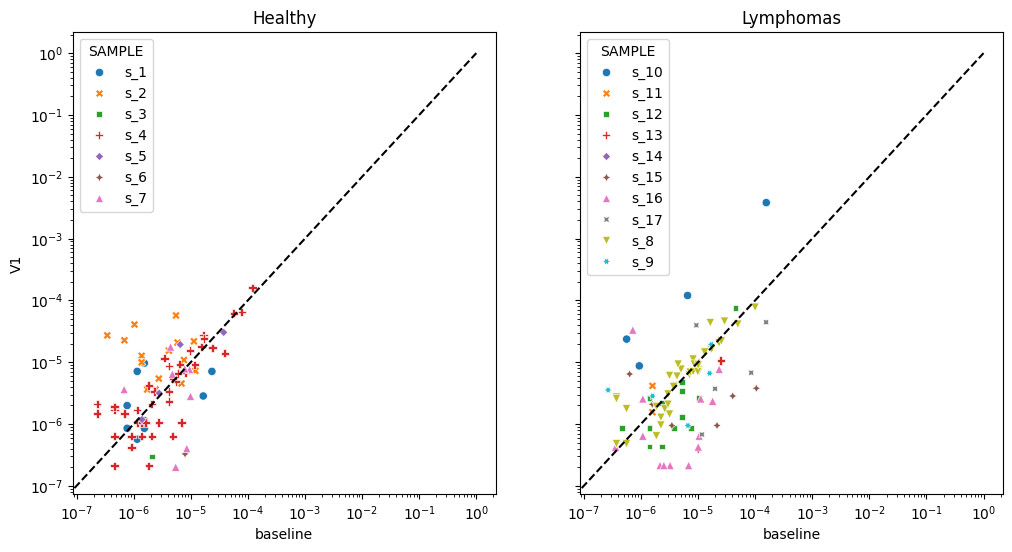

In [27]:
# plot V1 vs baseline, make two scatter plots, one 'Lymphomas' and one 'Healthy'
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharex=True, sharey=True)

# draw a line at x=y
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
# sns scatterplot symbol 
#sns.scatterplot(data=test_data.query('CONDITION == "Healthy"'), y='V1', x='baseline', ax=ax[0], alpha = 0.5)
sns.scatterplot(data=covid_specific.query('CONDITION == "Healthy"'), y='V1', x='baseline', hue = 'SAMPLE', ax=ax[0], style='SAMPLE')
#sns.scatterplot(data=test_data.query('CONDITION == "Lymphomas"'), y='V1', x='baseline', ax=ax[1], alpha = 0.5)
sns.scatterplot(data=covid_specific.query('CONDITION == "Lymphomas"'), y='V1', x='baseline', hue = 'SAMPLE', ax=ax[1], style='SAMPLE')
# add dots for the covid_specific data

# add titles to the subplots
ax[0].set_title('Healthy')
ax[1].set_title('Lymphomas')
# set log scale for both axes
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel('baseline')
ax[0].set_ylabel('V1')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set_xlabel('baseline')
ax[1].set_ylabel('V1')
plt.show()

In [28]:
covid_specific = pd.merge(data, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['junction_aa','v_call', 'j_call']], how='left', indicator=True)
covid_specific = covid_specific.query('_merge == "both"')
covid_specific.reset_index(drop=True, inplace=True)

covid_specific['junction_aa'] = covid_specific['clonotype'].str.split('_').str[1]
covid_specific['CDR3_length'] = covid_specific['junction_aa'].str.len()
covid_specific.head()

,clonotype,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,v_call,j_call,junction_aa,cloneFraction,cloneCount,_merge,CDR3_length
0,TRAV1-1_CAALNYGGSQGNLIF_TRAJ42,39670,s_7,baseline,Healthy,TRA,TRAV1-1,TRAJ42,CAALNYGGSQGNLIF,1.362981e-06,4.0,both,15
1,TRAV1-1_CAALNYGGSQGNLIF_TRAJ42,39700,s_1,baseline,Healthy,TRA,TRAV1-1,TRAJ42,CAALNYGGSQGNLIF,1.153848e-06,3.0,both,15
2,TRAV1-1_CAALNYGGSQGNLIF_TRAJ42,B2,s_7,V3,Healthy,TRA,TRAV1-1,TRAJ42,CAALNYGGSQGNLIF,3.550874e-07,1.0,both,15
3,TRAV1-1_CAGGGQKLLF_TRAJ16,6L,s_9,V3,Lymphomas,TRA,TRAV1-1,TRAJ16,CAGGGQKLLF,2.957134e-06,13.0,both,10
4,TRAV1-1_CAVLNYGGSQGNLIF_TRAJ42,27L,s_16,V3,Lymphomas,TRA,TRAV1-1,TRAJ42,CAVLNYGGSQGNLIF,2.553287e-06,7.0,both,15


In [29]:
kolmogorov = covid_specific.query('SAMPLE != "s_1" and SAMPLE != "s_10"')
kolmogorov['CDR3_length'] = kolmogorov['junction_aa'].str.len()
kolmogorov = kolmogorov.query('TCR_Chain == "TRB"')
kolmogorov

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_72667/382253109.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,clonotype,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,v_call,j_call,junction_aa,cloneFraction,cloneCount,_merge,CDR3_length
7084,TRBV10-1_CASEDSNTGELFF_TRBJ2-2,A9,s_2,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASEDSNTGELFF,6.291633e-07,2.0,both,13
7085,TRBV10-1_CASNGHNTGELFF_TRBJ2-2,A11,s_4,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASNGHNTGELFF,3.428489e-07,1.0,both,13
7086,TRBV10-1_CASRDRNTGELFF_TRBJ2-2,39670,s_7,baseline,Healthy,TRB,TRBV10-1,TRBJ2-2,CASRDRNTGELFF,4.429688e-06,13.0,both,13
7087,TRBV10-1_CASRDRNTGELFF_TRBJ2-2,B2,s_7,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASRDRNTGELFF,7.101748e-07,2.0,both,13
7088,TRBV10-1_CASREGNTGELFF_TRBJ2-2,A9,s_2,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASREGNTGELFF,6.291633e-07,2.0,both,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,TRBV9_CASSVVNTGELFF_TRBJ2-2,A11,s_4,V3,Healthy,TRB,TRBV9,TRBJ2-2,CASSVVNTGELFF,3.428489e-07,1.0,both,13
11621,TRBV9_CASSVVNTGELFF_TRBJ2-2,A9,s_2,V3,Healthy,TRB,TRBV9,TRBJ2-2,CASSVVNTGELFF,1.258327e-06,4.0,both,13
11622,TRBV9_CASSWGNTGELFF_TRBJ2-2,B2,s_7,V3,Healthy,TRB,TRBV9,TRBJ2-2,CASSWGNTGELFF,1.065262e-06,3.0,both,13
11623,TRBV9_CASTDGNTGELFF_TRBJ2-2,27L,s_16,V3,Lymphomas,TRB,TRBV9,TRBJ2-2,CASTDGNTGELFF,5.106574e-06,14.0,both,13


In [30]:
kolmogorov = kolmogorov.drop_duplicates(subset=['SAMPLE', 'TIMEPOINTS', 'CONDITION', 'junction_aa', 'CDR3_length'])
kolmogorov

,clonotype,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,v_call,j_call,junction_aa,cloneFraction,cloneCount,_merge,CDR3_length
7084,TRBV10-1_CASEDSNTGELFF_TRBJ2-2,A9,s_2,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASEDSNTGELFF,6.291633e-07,2.0,both,13
7085,TRBV10-1_CASNGHNTGELFF_TRBJ2-2,A11,s_4,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASNGHNTGELFF,3.428489e-07,1.0,both,13
7086,TRBV10-1_CASRDRNTGELFF_TRBJ2-2,39670,s_7,baseline,Healthy,TRB,TRBV10-1,TRBJ2-2,CASRDRNTGELFF,4.429688e-06,13.0,both,13
7087,TRBV10-1_CASRDRNTGELFF_TRBJ2-2,B2,s_7,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASRDRNTGELFF,7.101748e-07,2.0,both,13
7088,TRBV10-1_CASREGNTGELFF_TRBJ2-2,A9,s_2,V3,Healthy,TRB,TRBV10-1,TRBJ2-2,CASREGNTGELFF,6.291633e-07,2.0,both,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,TRBV9_CASSVVNTGELFF_TRBJ2-2,A11,s_4,V3,Healthy,TRB,TRBV9,TRBJ2-2,CASSVVNTGELFF,3.428489e-07,1.0,both,13
11621,TRBV9_CASSVVNTGELFF_TRBJ2-2,A9,s_2,V3,Healthy,TRB,TRBV9,TRBJ2-2,CASSVVNTGELFF,1.258327e-06,4.0,both,13
11622,TRBV9_CASSWGNTGELFF_TRBJ2-2,B2,s_7,V3,Healthy,TRB,TRBV9,TRBJ2-2,CASSWGNTGELFF,1.065262e-06,3.0,both,13
11623,TRBV9_CASTDGNTGELFF_TRBJ2-2,27L,s_16,V3,Lymphomas,TRB,TRBV9,TRBJ2-2,CASTDGNTGELFF,5.106574e-06,14.0,both,13


KS test statistic: 0.02608275230291618, p-value: 0.9930944633812997


Text(0.9, 0.9, 'Kolmogorov-Smirnov statistic: 0.0261\np-value: 0.9931')

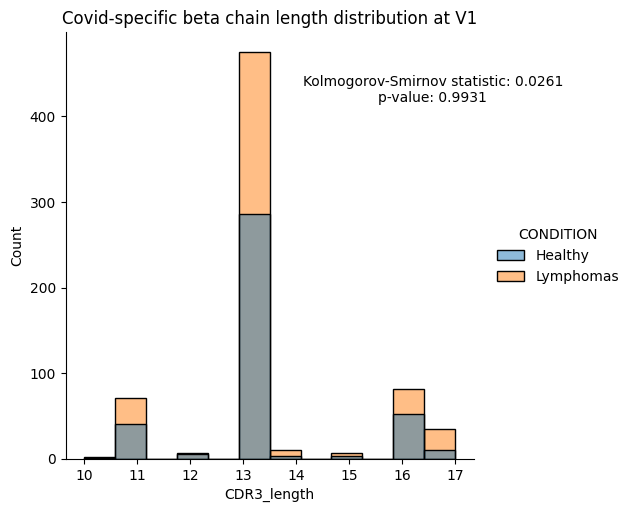

In [31]:
# Kolmogorov-Smirnov test for the distribution of CDR3 length between Healthy and Lymphomas at V1
ks_stat, ks_pval = ks_2samp(kolmogorov.query('CONDITION == "Healthy" and TIMEPOINTS == "V1" and TCR_Chain == "TRB"')['CDR3_length'],
                            kolmogorov.query('CONDITION == "Lymphomas" and TIMEPOINTS == "V1" and TCR_Chain == "TRB"')['CDR3_length'])
print(f'KS test statistic: {ks_stat}, p-value: {ks_pval}')

sns.displot(data=kolmogorov.query('TIMEPOINTS == "V1"'), x="CDR3_length", kind="hist", hue = 'CONDITION')
# add title
plt.title('Covid-specific beta chain length distribution at V1')
plt.text(0.9, 0.9, f'Kolmogorov-Smirnov statistic: {ks_stat:.4f}\np-value: {ks_pval:.4f}', ha='center', va='top', transform=plt.gca().transAxes)

KS test statistic: 0.03717666543180283, p-value: 0.5740014124009726


Text(0.9, 0.9, 'Kolmogorov-Smirnov statistic: 0.0372\np-value: 0.5740')

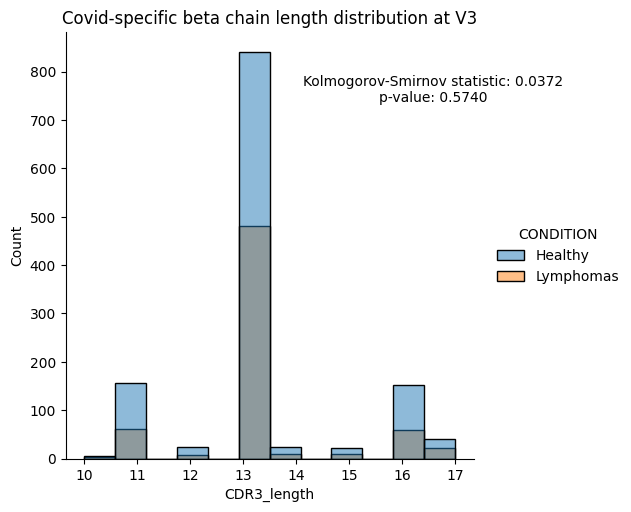

In [32]:
# Kolmogorov-Smirnov test for the distribution of CDR3 length between Healthy and Lymphomas at V3
ks_stat, ks_pval = ks_2samp(kolmogorov.query('CONDITION == "Healthy" and TIMEPOINTS == "V3" and TCR_Chain == "TRB"')['CDR3_length'],
                            kolmogorov.query('CONDITION == "Lymphomas" and TIMEPOINTS == "V3" and TCR_Chain == "TRB"')['CDR3_length'])
print(f'KS test statistic: {ks_stat}, p-value: {ks_pval}')

sns.displot(data=kolmogorov.query('TIMEPOINTS == "V3"'), x="CDR3_length", kind="hist", hue = 'CONDITION')
plt.title('Covid-specific beta chain length distribution at V3')
plt.text(0.9, 0.9, f'Kolmogorov-Smirnov statistic: {ks_stat:.4f}\np-value: {ks_pval:.4f}', ha='center', va='top', transform=plt.gca().transAxes)

KS test statistic: 0.017985067097164766, p-value: 0.9999996645501722


Text(0.9, 0.9, 'Kolmogorov-Smirnov statistic: 0.0180\np-value: 1.0000')

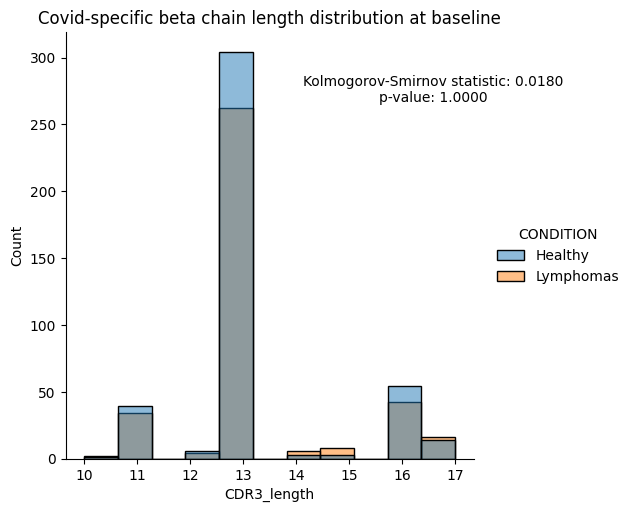

In [33]:
# Kolmogorov-Smirnov test for the distribution of CDR3 length between Healthy and Lymphomas at baseline
ks_stat, ks_pval = ks_2samp(kolmogorov.query('CONDITION == "Healthy" and TIMEPOINTS == "baseline" and TCR_Chain == "TRB"')['CDR3_length'],
                            kolmogorov.query('CONDITION == "Lymphomas" and TIMEPOINTS == "baseline" and TCR_Chain == "TRB"')['CDR3_length'])
print(f'KS test statistic: {ks_stat}, p-value: {ks_pval}')

sns.displot(data=kolmogorov.query('TIMEPOINTS == "baseline"'), x="CDR3_length", kind="hist", hue = 'CONDITION')
plt.title('Covid-specific beta chain length distribution at baseline')
plt.text(0.9, 0.9, f'Kolmogorov-Smirnov statistic: {ks_stat:.4f}\np-value: {ks_pval:.4f}', ha='center', va='top', transform=plt.gca().transAxes)

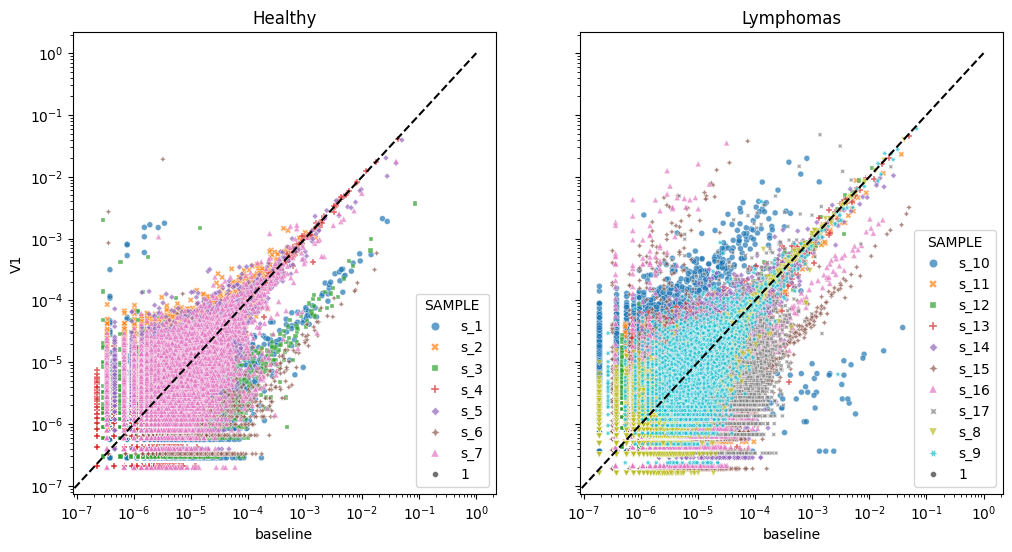

In [34]:
# plot V1 vs baseline, make two scatter plots, one 'Lymphomas' and one 'Healthy'
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharex=True, sharey=True)
# draw a line at x=y
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
# sns scatterplot symbol 
sns.scatterplot(data=test_data.query('CONDITION == "Healthy"'), y='V1', x='baseline', ax=ax[0], alpha = 0.7, hue = 'SAMPLE', style='SAMPLE', size = 1)
sns.scatterplot(data=test_data.query('CONDITION == "Lymphomas"'), y='V1', x='baseline', ax=ax[1], alpha = 0.7, hue = 'SAMPLE', style='SAMPLE', size = 1)

# add titles to the subplots
ax[0].set_title('Healthy')
ax[1].set_title('Lymphomas')
# set log scale for both axes
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel('baseline')
ax[0].set_ylabel('V1')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set_xlabel('baseline')
ax[1].set_ylabel('V1')
plt.show()

## Resampling

In [35]:
tcra_size_resample = round(uniques.query('not(CONDITION == "Healthy" and TIMEPOINTS == "V3") \
                                        and TCR_Chain == "TRA"')['countUniqueCDR3'].mean())
tcrb_size_resample = round(uniques.query('not(CONDITION == "Healthy" and TIMEPOINTS == "V3") \
                                        and TCR_Chain == "TRB"')['countUniqueCDR3'].mean())

In [36]:
tcrb_size_resample

59749

In [37]:
tcra_size_resample

57099

In [38]:
# resample data to get a distribution of unique CDR3s
# the probability that a row will be selected is proportional to the cloneFraction
# the number of unique rows to select is equal to the a value given
def resample(data, size, random_state = 42):
    return data.sample(n=size, replace=False, weights=data['cloneFraction'], random_state=random_state)

## 1000 fold resampling

In [39]:
def resampling_test(data, uniques):
    
    meanFractions = []

    for perm in tqdm(range(1000)):
        
        
        res = []
        
        for sample_id in uniques.query('CONDITION == "Healthy" and TIMEPOINTS == "V3"')['sample_id'].unique():
            
            resampled = resample(data.query('sample_id == @sample_id and TCR_Chain == "TRB"'), tcrb_size_resample, random_state = perm)
            
            res.append(resampled)
            
        res = pd.concat(res)
                
        res = pd.merge(res, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])
                    [['junction_aa','v_call', 'j_call']], how='left', indicator=True)

        res = res.query('_merge == "both"')
        
        res = res.groupby(
            ['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], as_index=False).agg({'cloneFraction': 'sum'})

        meanFractions.append(np.mean(res['cloneFraction']))
        
    return meanFractions

In [40]:
meanFractions = resampling_test(data, uniques)

  5%|▌         | 52/1000 [01:46<32:27,  2.05s/it]


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(meanFractions, columns=['Value'])
# group by Value and calculate the frequency
df = df.groupby('Value').size().reset_index(name='Frequency')
df

NameError: name 'meanFractions' is not defined

In [41]:
resampled_data = pd.DataFrame()
for sample_id in uniques.query('CONDITION == "Healthy" and TIMEPOINTS == "V3"')['sample_id'].unique():
    
    for chain in ['TRA', 'TRB']:
        
        if chain == 'TRA':
            resampled = resample(data.query('sample_id == @sample_id and TCR_Chain == @chain'), tcra_size_resample, random_state = 42)
        else:
            resampled = resample(data.query('sample_id == @sample_id and TCR_Chain == @chain'), tcrb_size_resample, random_state = 42)
            
        if resampled_data.empty:
            resampled_data = resampled
        else:
            resampled_data = pd.concat([resampled, resampled_data])

In [42]:
selected_resampling_covid = resampled_data.query('TCR_Chain == "TRB"')
selected_resampling_covid = pd.merge(selected_resampling_covid, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])
                    [['junction_aa','v_call', 'j_call']], how='left', indicator=True)

selected_resampling_covid = selected_resampling_covid.query('_merge == "both"')
selected_resampling_covid = selected_resampling_covid.groupby(['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'],
                                                              as_index=False).agg({'cloneFraction': 'sum'})['cloneFraction'].mean()

pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
mean_clone_dist = ro.globalenv['mean_clone_dist']
mean_clone_dist(df, selected_resampling_covid, PLOTSDIR)

NameError: name 'df' is not defined

## Second resampling version
### Resample by extracting the same number of reads as the average for the remaning samples

In [ ]:
tcra_size_resample = round(uniques.query('not(CONDITION == "Healthy" and TIMEPOINTS == "V3") \
                                        and TCR_Chain == "TRA"')['cloneCount'].mean())
tcrb_size_resample = round(uniques.query('not(CONDITION == "Healthy" and TIMEPOINTS == "V3") \
                                        and TCR_Chain == "TRB"')['cloneCount'].mean())

In [ ]:
tcrb_size_resample

1340327

In [ ]:
def resample(data, size, random_state = 42):
    
    return data.sample(n=size, replace=False, random_state=random_state)

## From now on we will use the resampled data

In [ ]:
# select if the sample is not Healthy V3
resampling_data = data.query('not(CONDITION == "Healthy" and TIMEPOINTS == "V3")')
resampling_data = pd.concat([resampling_data, resampled_data])
resampling_data = resampling_data.query('TCR_Chain == "TRB"')
resampling_data.reset_index(drop=True, inplace=True)

In [ ]:
# sum the cloneCount for each sample_id and recaluclate the cloneFraction for each clonotype
resampling_data['cloneFraction'] =  resampling_data['cloneCount'] / resampling_data.groupby('sample_id')['cloneCount'].transform('sum')

In [ ]:
data = resampling_data

In [ ]:
uniques = pd.DataFrame({'countUniqueCDR3': data.query('TCR_Chain == "TRA" or TCR_Chain == "TRB"').groupby(['sample_id', 'TCR_Chain'])['clonotype'].nunique()}).reset_index()
uniques = pd.merge(uniques, metadata, on = 'sample_id', how='left')

# group by sample_id and sum cloneCount
library_size = data.groupby(['sample_id','TCR_Chain']).agg({'cloneCount': 'sum'}).reset_index()
uniques = pd.merge(uniques, library_size, on = ['sample_id', 'TCR_Chain'], how='left')
uniques['normalizedUniqueCDR3'] = uniques['countUniqueCDR3'] / uniques['cloneCount']

In [ ]:
plotting.plot_nuniques_clonecounts(uniques, PLOTSDIR)

## Test repertoire differences at V3

/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/src/utils/plotting.py:128: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



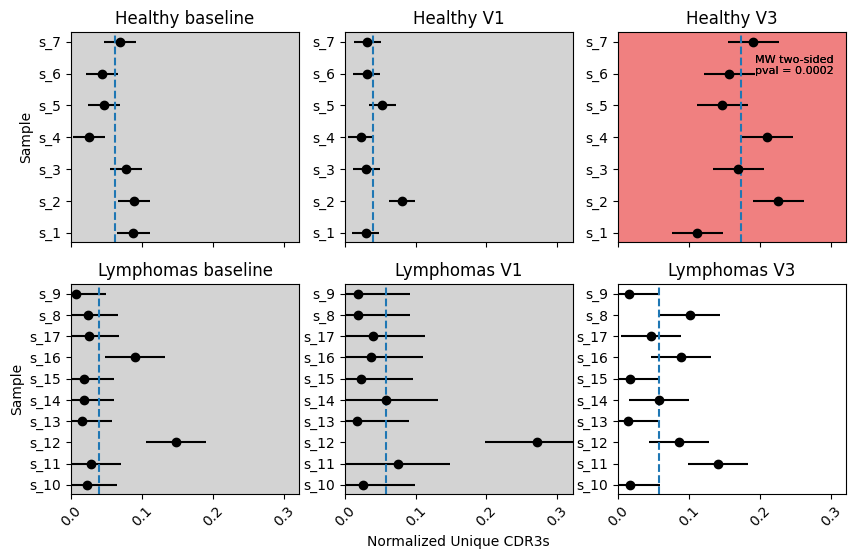

In [43]:
plotting.test_global_repertoire_differences(uniques, PLOTSDIR)

## Barplot Unique CDR3s

In [44]:
uniques.query('CONDITION == "Healthy"').to_csv(PROCESSEDDIR + 'healthy_uniques.csv', index=False)

In [45]:
plotting.plot_repertoire_sizes(uniques, PLOTSDIR)

## Sample 9 outlier clonotype (will be removed from the depth analysis)

In [46]:
s_9_data = pd.merge(data, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['junction_aa','v_call', 'j_call']], how='left', indicator=True)
s_9_data = s_9_data.query('SAMPLE == "s_9" and _merge == "both"')
s_9_data.sort_values(by=['cloneFraction'], ascending=False, inplace=True)
s_9_data.head()

,clonotype,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,v_call,j_call,junction_aa,cloneFraction,cloneCount,_merge
2659748,TRAV35_CAGRNYGGSQGNLIF_TRAJ42,5L,s_9,V1,Lymphomas,TRA,TRAV35,TRAJ42,CAGRNYGGSQGNLIF,0.000045,189.0,both
2601615,TRAV35_CAALLYGGSQGNLIF_TRAJ42,5L,s_9,V1,Lymphomas,TRA,TRAV35,TRAJ42,CAALLYGGSQGNLIF,0.000040,169.0,both
2616399,TRAV35_CAGLNYGGSQGNLIF_TRAJ42,5L,s_9,V1,Lymphomas,TRA,TRAV35,TRAJ42,CAGLNYGGSQGNLIF,0.000039,164.0,both
221209,TRAV12-1_CVVNIPTDSNYQLIW_TRAJ33,5L,s_9,V1,Lymphomas,TRA,TRAV12-1,TRAJ33,CVVNIPTDSNYQLIW,0.000033,141.0,both
2619725,TRAV35_CAGMNYGGSQGNLIF_TRAJ42,5L,s_9,V1,Lymphomas,TRA,TRAV35,TRAJ42,CAGMNYGGSQGNLIF,0.000031,132.0,both


## Prepare data for breadth and depth analysis

In [47]:
# take only beta chains
data = data.query('TCR_Chain == "TRB"')
data.reset_index(drop=True, inplace=True)

# group rows that have the same sample_id and junction_aa
breadth_depth_grouped_data = data.groupby(['junction_aa', 'sample_id', 'SAMPLE',
                                    'TIMEPOINTS', 'CONDITION', 'TCR_Chain', 'j_call', 'v_call'],
                                     as_index=False).agg({'cloneFraction': 'sum', 'cloneCount': 'sum',})
                                    # 'j_call': ','.join, 'v_call': ','.join})
                                    
breadth_depth_grouped_data.to_csv(PROCESSEDDIR + 'breadth-depth_grouped_data.csv', index=False)

## Clonal breadth

In [48]:
clonal_breadth_data = pd.read_csv(PROCESSEDDIR + 'breadth-depth_grouped_data.csv')

In [49]:
# Remove patients positive to SARS-CoV-2 at baseline
clonal_breadth_data = clonal_breadth_data.query('SAMPLE != "s_1" and SAMPLE != "s_10"')

In [50]:
clonal_breadth_data = pd.merge(clonal_breadth_data, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['junction_aa','v_call', 'j_call']], how='left', indicator=True)
clonal_breadth_data.head()

,junction_aa,sample_id,SAMPLE,TIMEPOINTS,CONDITION,TCR_Chain,j_call,v_call,cloneFraction,cloneCount,_merge
0,CAAAAANTGELFF,12L,s_11,V3,Lymphomas,TRB,TRBJ2-2,TRBV19,2.157544e-06,5.0,both
1,CAAAADSTDTQYF,A11,s_4,V3,Healthy,TRB,TRBJ2-3,TRBV6-2,6.856978e-07,2.0,left_only
2,CAAAADSTGELFF,13L,s_12,baseline,Lymphomas,TRB,TRBJ2-2,TRBV7-2,2.356350e-06,5.0,left_only
3,CAAAAELSYGYTF,B2,s_7,V3,Healthy,TRB,TRBJ1-2,TRBV7-9,2.130524e-06,6.0,left_only
4,CAAAAFYGYTF,39465,s_4,baseline,Healthy,TRB,TRBJ1-2,TRBV19,4.606287e-07,2.0,left_only


In [51]:
clonal_breadth_data = clonal_breadth_data.groupby(['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], as_index=False).apply(lambda x: x['_merge'].value_counts())
clonal_breadth_data['total'] = clonal_breadth_data['left_only'] + clonal_breadth_data['both']
clonal_breadth_data['fraction_sequences'] = clonal_breadth_data['both']/clonal_breadth_data['total']

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_72667/718788864.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [52]:
clonal_breadth_data = clonal_breadth_data.sort_values(by=['SAMPLE', 'TIMEPOINTS'], ascending=[True, False])

In [53]:
clonal_breadth_data.rename(columns={'fraction_sequences': 'Covid_clonal_breadth'}).reset_index(drop=True).to_csv(PROCESSEDDIR + 'share_clonal_breadth.csv', index=False)

### Clonal breadth correlation with AB titers

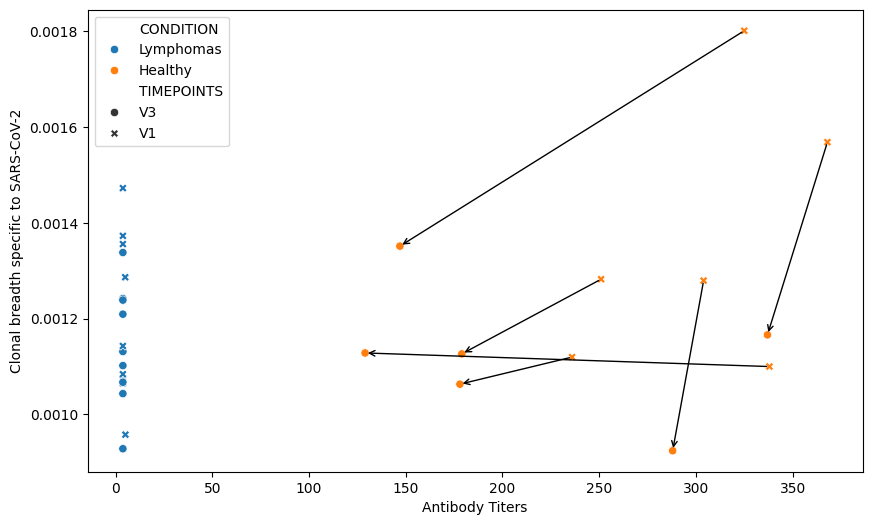

In [93]:
sns.scatterplot(pd.merge(clonal_breadth_data, metadata, how='inner').query('TIMEPOINTS != "baseline"'),
                x='AB_TITER', y='fraction_sequences', hue='CONDITION', style='TIMEPOINTS')
# remove grid
plt.grid(False)
# change y axis title
plt.ylabel('Clonal breadth specific to SARS-CoV-2')
plt.xlabel('Antibody Titers')

# link dots that have the same sample_id with an arrow
for sample in pd.merge(clonal_breadth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and CONDITION == "Healthy"')['SAMPLE'].unique():
    sample_data = pd.merge(clonal_breadth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and SAMPLE == @sample')
    
    # add arrow between the two points
    plt.annotate('', xy=(sample_data['AB_TITER'].values[0], sample_data['fraction_sequences'].values[0]),
                 xytext=(sample_data['AB_TITER'].values[1], sample_data['fraction_sequences'].values[1]),
                 arrowprops=dict(arrowstyle='->', color='black', lw=1))
    
# change dimensions
plt.gcf().set_size_inches(10, 6)

# save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_breadth_ab_titers.png', dpi=600, bbox_inches='tight')

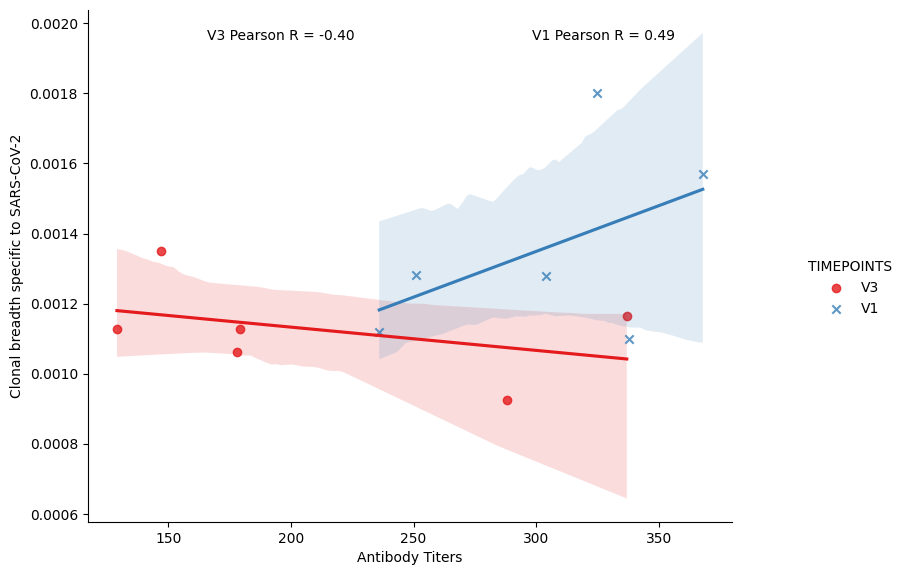

In [94]:
healthy_data = (pd.merge(clonal_breadth_data, metadata, how='inner')
                .query('TIMEPOINTS != "baseline" and CONDITION == "Healthy"'))


sns.lmplot(x="AB_TITER", y="fraction_sequences", hue="TIMEPOINTS", data=healthy_data, markers=["o", "x"], palette="Set1")
# change size of the plot
plt.gcf().set_size_inches(10, 6)
plt.ylabel('Clonal breadth specific to SARS-CoV-2')
plt.xlabel('Antibody Titers')

# add R^2 value to the plot for each timepoint
for i,timepoint in enumerate(healthy_data['TIMEPOINTS'].unique()):
    timepoint_data = healthy_data.query('TIMEPOINTS == @timepoint')
    r, p = pearsonr(timepoint_data['AB_TITER'], timepoint_data['fraction_sequences'])
    plt.text(0.3+i*0.5, .95, f'{timepoint} Pearson R = {r:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    
    # save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_breadth_ab_titers_correlation.png', dpi=600, bbox_inches='tight')

In [95]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
plot_betweenstats_breadth = ro.globalenv['plot_betweenstats_breadth']
plot_betweenstats_breadth(clonal_breadth_data[['fraction_sequences',  'CONDITION', 'TIMEPOINTS', 'SAMPLE']], PLOTSDIR)

Saving 8 x 7 in image
Saving 8 x 7 in image
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 8 x 7 in image
Error in `geom_label_repel()` at src/utils/plotting.R:150:3:
! Problem while converting geom to grob.
ℹ Error occurred in the 4th layer.
Caused by error in `parse()`:
! <text>:1:31: ',' inatteso
1: hat(mu)*scriptstyle(median)==0,
                                  ^
Run `rlang::last_trace()` to see where the error occurred.


RRuntimeError: Errore in geom_label_repel(stat = "summary", fun = median, size = 3, aes(label = paste0("hat(mu)*scriptstyle(median)==",  : 
  
ℹ Error occurred in the 4th layer.
Caused by error in `parse()`:
! <text>:1:31: ',' inatteso
1: hat(mu)*scriptstyle(median)==0,
                                  ^


In [96]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
plot_scatteratio_breadth = ro.globalenv['plot_scatteratio_breadth']
plot_scatteratio_breadth(clonal_breadth_data[['fraction_sequences', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], PLOTSDIR)

R[write to console]: Caricamento del pacchetto richiesto: scales

R[write to console]: 
Caricamento pacchetto: ‘scales’


R[write to console]: Il seguente oggetto è mascherato da ‘package:purrr’:

    discard


R[write to console]: Il seguente oggetto è mascherato da ‘package:readr’:

    col_factor




Saving 7 x 7 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/scatteratio_breadth_R.png'],
      dtype='<U90')

In [97]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
linear_mixed_model = ro.globalenv['linear_mixed_model']
linear_mixed_model(clonal_breadth_data[['fraction_sequences', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], MODELSDIR)

R[write to console]: Caricamento del pacchetto richiesto: lme4

R[write to console]: Caricamento del pacchetto richiesto: Matrix

R[write to console]: 
Caricamento pacchetto: ‘Matrix’


R[write to console]: I seguenti oggetti sono mascherati da ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Caricamento del pacchetto richiesto: lmerTest

R[write to console]: 
Caricamento pacchetto: ‘lmerTest’


R[write to console]: Il seguente oggetto è mascherato da ‘package:lme4’:

    lmer


R[write to console]: Il seguente oggetto è mascherato da ‘package:stats’:

    step


R[write to console]: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



CONDITION = Healthy:
 contrast       estimate       SE df t.ratio p.value
 baseline - V1 -3,39e-04 8,15e-05 26  -4,154  0,0009
 baseline - V3 -1,07e-04 8,15e-05 26  -1,307  0,4043
 V1 - V3        2,32e-04 8,15e-05 26   2,847  0,0224

CONDITION = Lymphomas:
 contrast       estimate       SE df t.ratio p.value
 baseline - V1 -1,04e-04 6,66e-05 26  -1,557  0,2818
 baseline - V3 -4,70e-05 6,66e-05 26  -0,706  0,7622
 V1 - V3        5,67e-05 6,66e-05 26   0,851  0,6750

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 
Saving 10 x 7 in image


R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Saving 10 x 7 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/models/lmm_model_breadth_pwpp.png'],
      dtype='<U92')

## Clonal depth

In [98]:
clonal_depth_data = pd.read_csv(PROCESSEDDIR + 'breadth-depth_grouped_data.csv')
clonal_depth_data = clonal_depth_data.query('SAMPLE != "s_1" and SAMPLE != "s_10"')

In [99]:
clonal_depth_data = pd.merge(clonal_depth_data, DETECT_predictions.drop_duplicates(subset=['junction_aa','v_call', 'j_call'])[['junction_aa','v_call', 'j_call']], how='left', indicator=True)
clonal_depth_data = clonal_depth_data.query('_merge == "both"')
clonal_depth_data.reset_index(drop=True, inplace=True)

In [100]:
clonal_depth_data = clonal_depth_data.groupby(['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], as_index=False).agg({'cloneFraction': 'sum'})
clonal_depth_data = pd.merge(clonal_depth_data, metadata, on=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], how='left') 
clonal_depth_data = clonal_depth_data.sort_values(by=['SAMPLE', 'TIMEPOINTS'], ascending=[True, False])

In [101]:
clonal_depth_data[['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE', 'cloneFraction']].rename(columns={'cloneFraction': 'Covid_clonal_depth'}).reset_index(drop=True).to_csv(PROCESSEDDIR + 'share_clonal_depth.csv', index=False)

In [102]:
clonal_breadth_data.rename(columns={'fraction_sequences': 'Covid_clonal_breadth'}).reset_index(drop=True).to_csv(PROCESSEDDIR + 'share_clonal_breadth.csv', index=False)

### Clonal depth correlation with AB titers

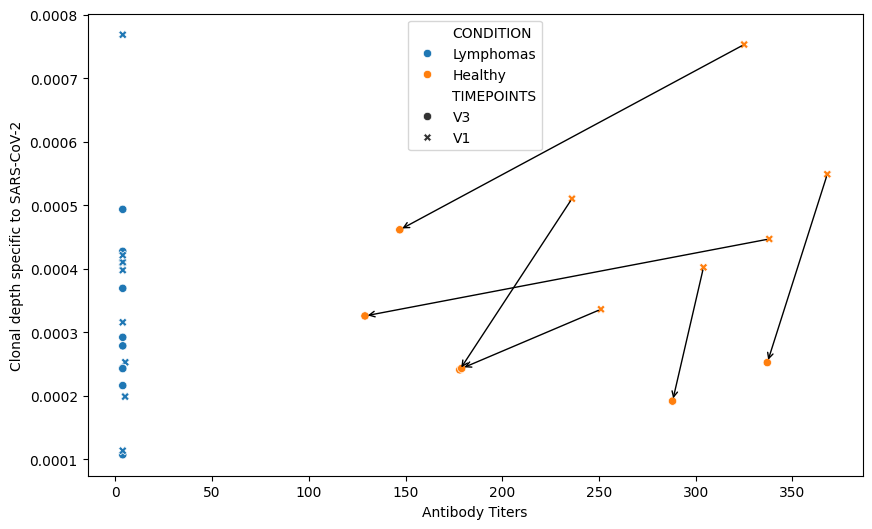

In [106]:
sns.scatterplot(pd.merge(clonal_depth_data, metadata, how='inner').query('TIMEPOINTS != "baseline"'),
                x='AB_TITER', y='cloneFraction', hue='CONDITION', style='TIMEPOINTS')
# remove grid
plt.grid(False)
# change y axis title
plt.ylabel('Clonal depth specific to SARS-CoV-2')
plt.xlabel('Antibody Titers')

# link dots that have the same sample_id with an arrow
for sample in pd.merge(clonal_depth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and CONDITION == "Healthy"')['SAMPLE'].unique():
    sample_data = pd.merge(clonal_depth_data, metadata, how='inner').query('TIMEPOINTS != "baseline" and SAMPLE == @sample')
    
    # add arrow between the two points
    plt.annotate('', xy=(sample_data['AB_TITER'].values[0], sample_data['cloneFraction'].values[0]),
                 xytext=(sample_data['AB_TITER'].values[1], sample_data['cloneFraction'].values[1]),
                 arrowprops=dict(arrowstyle='->', color='black', lw=1))
    
# change dimensions
plt.gcf().set_size_inches(10, 6)

# save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_depth_ab_titers.png', dpi=600, bbox_inches='tight')

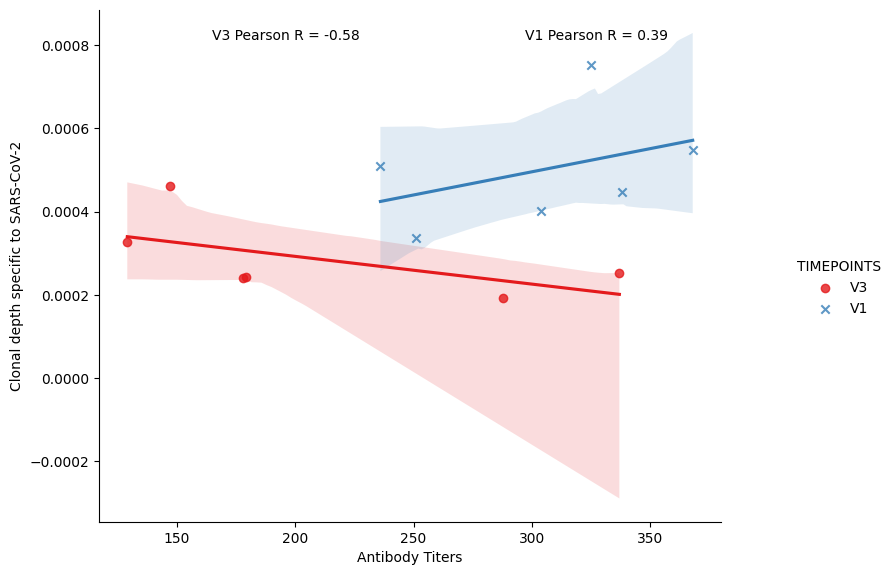

In [107]:
healthy_data = (pd.merge(clonal_depth_data, metadata, how='inner')
                .query('TIMEPOINTS != "baseline" and CONDITION == "Healthy"'))


sns.lmplot(x="AB_TITER", y="cloneFraction", hue="TIMEPOINTS", data=healthy_data, markers=["o", "x"], palette="Set1")
# change size of the plot
plt.gcf().set_size_inches(10, 6)
plt.ylabel('Clonal depth specific to SARS-CoV-2')
plt.xlabel('Antibody Titers')

# add R^2 value to the plot for each timepoint
for i,timepoint in enumerate(healthy_data['TIMEPOINTS'].unique()):
    timepoint_data = healthy_data.query('TIMEPOINTS == @timepoint')
    r, p = pearsonr(timepoint_data['AB_TITER'], timepoint_data['cloneFraction'])
    plt.text(0.3+i*0.5, .95, f'{timepoint} Pearson R = {r:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    
    # save the plot at 600 dpi
plt.savefig(PLOTSDIR + 'clonal_depth_ab_titers_correlation.png', dpi=600, bbox_inches='tight')

In [93]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
plot_betweenstats_clone_fraction = ro.globalenv['plot_betweenstats_clone_fraction']
plot_betweenstats_clone_fraction(clonal_depth_data[['cloneFraction',  'CONDITION', 'TIMEPOINTS', 'SAMPLE']], PLOTSDIR)

Saving 8 x 5 in image
Saving 8 x 5 in image
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 8 x 5 in image
Saving 30 x 5 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/composite_clonefraction.png'],
      dtype='<U92')

In [94]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
plot_clonal_depth = ro.globalenv['plot_clonal_depth']
plot_clonal_depth(clonal_depth_data[['cloneFraction', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], PLOTSDIR)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 8 x 5 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/scatteratio_depth.png'],
      dtype='<U86')

In [95]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
linear_mixed_model = ro.globalenv['linear_mixed_model']
linear_mixed_model(clonal_depth_data[['cloneFraction', 'CONDITION', 'TIMEPOINTS', 'SAMPLE']], MODELSDIR)

CONDITION = Healthy:
 contrast       estimate       SE df t.ratio p.value
 baseline - V1 -3.70e-04 0.000142 26  -2.601  0.0389
 baseline - V3  1.81e-04 0.000142 26   1.274  0.4221
 V1 - V3        5.51e-04 0.000142 26   3.875  0.0018

CONDITION = Lymphomas:
 contrast       estimate       SE df t.ratio p.value
 baseline - V1 -2.42e-04 0.000116 26  -2.085  0.1127
 baseline - V3 -9.42e-05 0.000116 26  -0.812  0.6992
 V1 - V3        1.48e-04 0.000116 26   1.273  0.4228

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 
Saving 10 x 5 in image


R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Saving 10 x 5 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/models/lmm_model_depth_pwpp.png'],
      dtype='<U90')

## Report LLMs

In [163]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
export_lmm_results = ro.globalenv['export_lmm_results']
export_lmm_results(MODELSDIR)

Saving 10 x 7 in image


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/models/models_summs.png'],
      dtype='<U82')

## V Gene usage

In [133]:
combined_predictions_hla_test = combined_predictions.query('SAMPLE != "s_1" and SAMPLE != "s_10"').pivot(index='SAMPLE', columns='locus', values='match')
combined_predictions_hla_test['HLA_A'] = combined_predictions_hla_test['HLA-A'].str.split('*').str[1]
combined_predictions_hla_test['HLA_B'] = combined_predictions_hla_test['HLA-B'].str.split('*').str[1]
combined_predictions_hla_test['HLA_C'] = combined_predictions_hla_test['HLA-C'].str.split('*').str[1]
metadata_test = pd.merge(metadata, combined_predictions_hla_test, on='SAMPLE', how='left')
metadata_test = metadata_test[['sample_id', 'SAMPLE', 'CONDITION', 'TIMEPOINTS', 'HLA_A', 'HLA_B', 'HLA_C']].query('SAMPLE != "s_1" and SAMPLE != "s_10"')
metadata_test = pd.merge(metadata_test, clonal_breadth_data[['sample_id', 'fraction_sequences']], on='sample_id', how='left')

In [134]:
trbv_gene_usage = data.query('TCR_Chain == "TRB"').query('SAMPLE != "s_1" and SAMPLE != "s_10"')
#trbv_gene_usage = trbv_gene_usage[trbv_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]
rows_to_remove = trbv_gene_usage.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
trbv_gene_usage = trbv_gene_usage[~trbv_gene_usage.isin(rows_to_remove)].dropna()
#trbv_gene_usage['Comparison_stat'] = trbv_gene_usage['CONDITION'] + ' ' + trbv_gene_usage['TIMEPOINTS']
trbv_gene_usage = trbv_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS'], columns='v_call', values='cloneFraction', fill_value=0, aggfunc='sum')
trbv_gene_usage.head()


,,v_call,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,TRBV12-5,TRBV13,...,TRBV6-8,TRBV6-9,TRBV7-2,TRBV7-3,TRBV7-4,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9
sample_id,CONDITION,TIMEPOINTS,,,,,,,,,,,,,,,,,,,,,
10L,Lymphomas,baseline,0.000118,0.001498,0.015993,0.002209,0.006286,0.000937,0.027293,0.019672,0.006722,0.005878,...,0.000200,0.000122,0.053670,0.017057,0.000243,0.008340,0.005140,0.023542,0.116174,0.023170
11L,Lymphomas,V1,0.000183,0.001480,0.017011,0.002869,0.010748,0.001588,0.028208,0.028266,0.005678,0.004126,...,0.000084,0.000140,0.054832,0.015757,0.000161,0.008914,0.005531,0.023736,0.091350,0.022106
12L,Lymphomas,V3,0.000117,0.001515,0.012553,0.002139,0.009171,0.001144,0.027136,0.032470,0.007771,0.003939,...,0.000037,0.000091,0.044680,0.011338,0.000146,0.006574,0.005716,0.021578,0.130204,0.020624
13L,Lymphomas,baseline,0.001745,0.003279,0.023997,0.003813,0.019404,0.002005,0.046510,0.040860,0.004412,0.003111,...,0.000179,0.000161,0.065218,0.022143,0.000305,0.009527,0.002410,0.027884,0.035446,0.016095
14L,Lymphomas,V1,0.001436,0.003434,0.016460,0.002974,0.022037,0.002077,0.053651,0.031288,0.003237,0.003603,...,0.000150,0.000130,0.056604,0.020085,0.000257,0.008260,0.002038,0.028005,0.043185,0.014969


In [135]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap = ro.globalenv['correlation_heatmap']
correlation_heatmap(pd.merge(trbv_gene_usage.reset_index(),
                             metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), PLOTSDIR)

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x493ee30d0> [7]
R classes: ('function',)

In [136]:
pd.merge(trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS']).sort_values(by=['sample_id']),
                            metadata_test.query('TIMEPOINTS == @time').reset_index(drop=True)[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']].sort_values(by=['sample_id']),
                            on='sample_id', how='left')

,sample_id,CONDITION,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,...,TRBV7-4,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9,SAMPLE,HLA_A,HLA_B,HLA_C
0,12L,Lymphomas,0.000117,0.001515,0.012553,0.002139,0.009171,0.001144,0.027136,0.032470,...,0.000146,0.006574,0.005716,0.021578,0.130204,0.020624,s_11,03:01,07:02,07:02
1,15L,Lymphomas,0.001956,0.003223,0.023089,0.003578,0.019324,0.002451,0.043797,0.039862,...,0.000237,0.008629,0.002197,0.019465,0.039566,0.016534,s_12,03:01,14:02,08:02
2,18L,Lymphomas,0.007083,0.003932,0.012930,0.002213,0.050475,0.002761,0.018355,0.016737,...,0.000094,0.010300,0.001711,0.018976,0.033842,0.014623,s_13,29:02,35:01,04:01
3,21L,Lymphomas,0.004535,0.031458,0.020636,0.002412,0.032489,0.001848,0.025902,0.020877,...,0.000622,0.014042,0.011742,0.017429,0.046119,0.008430,s_14,02:01,18:01,07:01
4,24L,Lymphomas,0.002336,0.005187,0.008472,0.000690,0.045780,0.003663,0.010840,0.210734,...,0.000028,0.008261,0.000542,0.019185,0.039030,0.011372,s_15,23:01,35:01,04:01
5,27L,Lymphomas,0.001410,0.007791,0.026201,0.004294,0.012328,0.003470,0.047433,0.020060,...,0.000354,0.007624,0.000968,0.016345,0.047253,0.026366,s_16,02:01,44:02,06:02
6,30L,Lymphomas,0.001155,0.002576,0.012872,0.001665,0.010642,0.006377,0.024469,0.015371,...,0.001488,0.007009,0.001544,0.020210,0.034188,0.014575,s_17,30:01,39:01,06:02
7,3L,Lymphomas,0.001264,0.004960,0.024837,0.001362,0.016531,0.004059,0.027742,0.004173,...,0.000340,0.023865,0.001114,0.016165,0.038846,0.013787,s_8,02:01,35:01,08:01
8,6L,Lymphomas,0.001237,0.001906,0.008424,0.015584,0.009182,0.001250,0.013216,0.082690,...,0.000094,0.007172,0.000829,0.190349,0.028101,0.017741,s_9,02:01,18:01,06:02
9,A10,Healthy,0.000869,0.001548,0.010484,0.001684,0.006627,0.000767,0.013677,0.278269,...,0.000135,0.026868,0.000796,0.006085,0.047932,0.027678,s_3,02:01,35:01,06:02


In [137]:
pd.merge(trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS']),
                            metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left')

,sample_id,CONDITION,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,...,TRBV7-4,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9,SAMPLE,HLA_A,HLA_B,HLA_C
0,12L,Lymphomas,0.000117,0.001515,0.012553,0.002139,0.009171,0.001144,0.027136,0.032470,...,0.000146,0.006574,0.005716,0.021578,0.130204,0.020624,s_11,03:01,07:02,07:02
1,15L,Lymphomas,0.001956,0.003223,0.023089,0.003578,0.019324,0.002451,0.043797,0.039862,...,0.000237,0.008629,0.002197,0.019465,0.039566,0.016534,s_12,03:01,14:02,08:02
2,18L,Lymphomas,0.007083,0.003932,0.012930,0.002213,0.050475,0.002761,0.018355,0.016737,...,0.000094,0.010300,0.001711,0.018976,0.033842,0.014623,s_13,29:02,35:01,04:01
3,21L,Lymphomas,0.004535,0.031458,0.020636,0.002412,0.032489,0.001848,0.025902,0.020877,...,0.000622,0.014042,0.011742,0.017429,0.046119,0.008430,s_14,02:01,18:01,07:01
4,24L,Lymphomas,0.002336,0.005187,0.008472,0.000690,0.045780,0.003663,0.010840,0.210734,...,0.000028,0.008261,0.000542,0.019185,0.039030,0.011372,s_15,23:01,35:01,04:01
5,27L,Lymphomas,0.001410,0.007791,0.026201,0.004294,0.012328,0.003470,0.047433,0.020060,...,0.000354,0.007624,0.000968,0.016345,0.047253,0.026366,s_16,02:01,44:02,06:02
6,30L,Lymphomas,0.001155,0.002576,0.012872,0.001665,0.010642,0.006377,0.024469,0.015371,...,0.001488,0.007009,0.001544,0.020210,0.034188,0.014575,s_17,30:01,39:01,06:02
7,3L,Lymphomas,0.001264,0.004960,0.024837,0.001362,0.016531,0.004059,0.027742,0.004173,...,0.000340,0.023865,0.001114,0.016165,0.038846,0.013787,s_8,02:01,35:01,08:01
8,6L,Lymphomas,0.001237,0.001906,0.008424,0.015584,0.009182,0.001250,0.013216,0.082690,...,0.000094,0.007172,0.000829,0.190349,0.028101,0.017741,s_9,02:01,18:01,06:02
9,A10,Healthy,0.000869,0.001548,0.010484,0.001684,0.006627,0.000767,0.013677,0.278269,...,0.000135,0.026868,0.000796,0.006085,0.047932,0.027678,s_3,02:01,35:01,06:02


In [138]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap_pertime = ro.globalenv['correlation_heatmap_pertime']

for time in trbv_gene_usage.reset_index()['TIMEPOINTS'].unique():
    correlation_heatmap_pertime(pd.merge(trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS']),
                            metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), time, PLOTSDIR)    

### Covid specific V  gene usage

In [139]:
trbv_gene_usage = data.query('TCR_Chain == "TRB"').query('SAMPLE != "s_1" and SAMPLE != "s_10"')
trbv_gene_usage = trbv_gene_usage[trbv_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]
rows_to_remove = trbv_gene_usage.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
trbv_gene_usage = trbv_gene_usage[~trbv_gene_usage.isin(rows_to_remove)].dropna()
#trbv_gene_usage['Comparison_stat'] = trbv_gene_usage['CONDITION'] + ' ' + trbv_gene_usage['TIMEPOINTS']
trbv_gene_usage = trbv_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS'], columns='v_call', values='cloneFraction', fill_value=0, aggfunc='sum')
trbv_gene_usage.head()


,,v_call,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,TRBV12-5,TRBV13,...,TRBV6-5,TRBV6-6,TRBV7-2,TRBV7-3,TRBV7-4,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9
sample_id,CONDITION,TIMEPOINTS,,,,,,,,,,,,,,,,,,,,,
10L,Lymphomas,baseline,0.000000,0.000000,0.000014,0.0,0.000000,0.0,0.000003,0.0,0.000000,0.0,...,0.000000,0.000002,0.000032,0.000044,0.0,0.000000,0.000000,0.000006,0.000041,0.000000
11L,Lymphomas,V1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000022,0.0,0.000000,0.0,...,0.000000,0.000005,0.000018,0.000011,0.0,0.000000,0.000000,0.000013,0.000081,0.000000
12L,Lymphomas,V3,0.000000,0.000000,0.000002,0.0,0.000009,0.0,0.000043,0.0,0.000000,0.0,...,0.000003,0.000022,0.000053,0.000009,0.0,0.000003,0.000006,0.000014,0.000034,0.000026
13L,Lymphomas,baseline,0.000000,0.000000,0.000015,0.0,0.000000,0.0,0.000046,0.0,0.000000,0.0,...,0.000000,0.000038,0.000061,0.000067,0.0,0.000000,0.000000,0.000004,0.000068,0.000020
14L,Lymphomas,V1,0.000003,0.000001,0.000012,0.0,0.000003,0.0,0.000045,0.0,0.000005,0.0,...,0.000011,0.000012,0.000073,0.000071,0.0,0.000011,0.000008,0.000009,0.000100,0.000032


In [140]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap = ro.globalenv['correlation_heatmap']
correlation_heatmap(pd.merge(trbv_gene_usage.reset_index(),
                             metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), PLOTSDIR)

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x3984ce950> [7]
R classes: ('function',)

In [153]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
correlation_heatmap_pertime = ro.globalenv['correlation_heatmap_pertime']

for time in trbv_gene_usage.reset_index()['TIMEPOINTS'].unique():
    correlation_heatmap_pertime(pd.merge(trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS']),
                            metadata_test[['sample_id', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C']],
                            on='sample_id', how='left'), time, PLOTSDIR)

Cluster Analysis for Timepoint baseline:
Contingency Table for Cluster 1:
       
        Healthy Lymphomas
  FALSE       6         4
  TRUE        0         5
Contingency Table for Cluster 3:
       
        Healthy Lymphomas
  FALSE       5         7
  TRUE        1         2
Contingency Table for Cluster 4:
       
        Healthy Lymphomas
  FALSE       5         8
  TRUE        1         1
Contingency Table for Cluster 2:
       
        Healthy Lymphomas
  FALSE       2         8
  TRUE        4         1
[1] "P-Values from Fisher Tests:"
[1] 0.04395604 1.00000000 1.00000000 0.08891109
[1] "Adjusted P-Values:"
[1] 0.1758242 1.0000000 1.0000000 0.1778222
Cluster Analysis for Timepoint V1:
Contingency Table for Cluster 1:
       
        Healthy Lymphomas
  FALSE       6         7
  TRUE        0         2
Contingency Table for Cluster 2:
       
        Healthy Lymphomas
  FALSE       4         7
  TRUE        2         2
Contingency Table for Cluster 3:
       
        Healthy Ly

In [150]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
pca_biplot_vgenes = ro.globalenv['pca_biplot_vgenes']
pca_biplot_vgenes(trbv_gene_usage.reset_index(drop=True),
                  pd.merge(trbv_gene_usage.reset_index()[['sample_id', 'CONDITION', 'TIMEPOINTS']], 
                  metadata_test, on = ['sample_id', 'CONDITION', 'TIMEPOINTS'],
                  how='left')[['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C', 'fraction_sequences']], PLOTSDIR)

R[write to console]: Caricamento del pacchetto richiesto: gridExtra

R[write to console]: 
Caricamento pacchetto: ‘gridExtra’


R[write to console]: Il seguente oggetto è mascherato da ‘package:dplyr’:

    combine


R[write to console]: Caricamento del pacchetto richiesto: broom

R[write to console]: Caricamento del pacchetto richiesto: limma

R[write to console]: Caricamento del pacchetto richiesto: BiocParallel

R[write to console]: 
Caricamento pacchetto: ‘variancePartition’


R[write to console]: Il seguente oggetto è mascherato da ‘package:limma’:

    topTable




[1] "Dimensions of variance_input:"
[1] 45 45
[1] "Dimensions of metadata:"
[1] 45  9
[1] "Metadata summary:"
  sample_id             CONDITION     TIMEPOINTS     SAMPLE       HLA_A   
 Length:45          Healthy  :18   baseline:15   s_11   : 3   02:01  :18  
 Class :character   Lymphomas:27   V1      :15   s_12   : 3   03:01  : 6  
 Mode  :character                  V3      :15   s_13   : 3   26:01  : 6  
                                                 s_14   : 3   01:01  : 3  
                                                 s_15   : 3   23:01  : 3  
                                                 s_16   : 3   24:02  : 3  
                                                 (Other):27   (Other): 6  
   HLA_B        HLA_C    fraction_sequences   CovidBreadth      
 07:02: 9   06:02  :12   Min.   :0.0007317   Min.   :0.0007317  
 14:02: 3   04:01  : 9   1st Qu.:0.0010430   1st Qu.:0.0010430  
 18:01: 9   07:02  : 9   Median :0.0011310   Median :0.0011310  
 35:01:15   01:02  : 3   Mean 

2


In [69]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')


pca_biplot_vgenes_pertime = ro.globalenv['pca_biplot_vgenes_pertime']

for time in trbv_gene_usage.reset_index()['TIMEPOINTS'].unique():
    trbv_time = trbv_gene_usage.reset_index().query('TIMEPOINTS == @time').drop(columns=['TIMEPOINTS'])
    trbv_time.set_index(['sample_id', 'CONDITION'], inplace=True)
    pca_biplot_vgenes_pertime(trbv_time,
                              pd.merge(trbv_time.reset_index()[['sample_id', 'CONDITION']],
                              metadata_test, on = ['sample_id', 'CONDITION'],
                              how = 'left')[['sample_id', 'CONDITION', 'SAMPLE', 'HLA_A', 'HLA_B', 'HLA_C', 'fraction_sequences']], time, PLOTSDIR)

[1] "Dimensions of variance_input:"
[1] 15 42
[1] "Dimensions of metadata:"
[1] 15  8
[1] "Metadata summary:"
  sample_id             CONDITION     SAMPLE      HLA_A     HLA_B       HLA_C  
 Length:15          Healthy  :6   s_11   :1   02:01  :6   07:02:3   06:02  :4  
 Class :character   Lymphomas:9   s_12   :1   03:01  :2   14:02:1   04:01  :3  
 Mode  :character                 s_13   :1   26:01  :2   18:01:3   07:02  :3  
                                  s_14   :1   01:01  :1   35:01:5   01:02  :1  
                                  s_15   :1   23:01  :1   39:01:1   05:01  :1  
                                  s_16   :1   24:02  :1   44:02:2   07:01  :1  
                                  (Other):9   (Other):2             (Other):2  
 fraction_sequences   CovidBreadth      
 Min.   :0.0007317   Min.   :0.0007317  
 1st Qu.:0.0009803   1st Qu.:0.0009803  
 Median :0.0010512   Median :0.0010512  
 Mean   :0.0010662   Mean   :0.0010662  
 3rd Qu.:0.0011829   3rd Qu.:0.0011829  
 Max

### Test expanding/contracting clonotypes

In [99]:
expansion_contraction = data.query('TCR_Chain == "TRB"').query('SAMPLE != "s_1" and SAMPLE != "s_10"')
expansion_contraction = expansion_contraction[['clonotype', 'SAMPLE', 'CONDITION', 'cloneFraction', 'TIMEPOINTS', 'v_call', 'j_call', 'junction_aa']]
rows_to_remove = expansion_contraction.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
expansion_contraction = expansion_contraction[~expansion_contraction.isin(rows_to_remove)].dropna().reset_index(drop=True)
# pivot the data so that one column is the cloneFraction at TIMEPOINTS "baseline" and one at "V1"
expansion_contraction = expansion_contraction.pivot_table(index=['clonotype', 'SAMPLE', 'CONDITION'], columns='TIMEPOINTS', values='cloneFraction', aggfunc='sum').reset_index()
expansion_contraction.fillna(0, inplace=True)

# calculate the fold change between V1 and baseline
expansion_contraction['delta_1'] = expansion_contraction['V1']  - expansion_contraction['baseline']
expansion_contraction['delta_2'] = expansion_contraction['V3'] - expansion_contraction['V1']

expansion_contraction['v_call'] = expansion_contraction['clonotype'].str.split('_').str[0]

expansion_contraction = pd.merge(expansion_contraction, DETECT_predictions[['clonotype']], on='clonotype', how='inner')
expansion_contraction['concave'] = np.where((expansion_contraction['V1'] < expansion_contraction['baseline'])
                                              & (expansion_contraction['V3'] > expansion_contraction['V1']), 1, 0)
expansion_contraction.sort_values('SAMPLE', inplace=True)
expansion_contraction.fillna(0, inplace=True)
expansion_contraction.reset_index(drop=True, inplace=True)
expansion_contraction

,clonotype,SAMPLE,CONDITION,V1,V3,baseline,delta_1,delta_2,v_call,concave
0,TRBV5-8_CASSPLSGGNTGELFF_TRBJ2-2,s_11,Lymphomas,0.000000,0.000002,0.0,0.000000,0.000002,TRBV5-8,0
1,TRBV5-4_CASSRENTGELFF_TRBJ2-2,s_11,Lymphomas,0.000000,0.000002,0.0,0.000000,0.000002,TRBV5-4,0
2,TRBV2_CASSWANTGELFF_TRBJ2-2,s_11,Lymphomas,0.000011,0.000000,0.0,0.000011,-0.000011,TRBV2,0
3,TRBV27_CASSLANTGELFF_TRBJ2-2,s_11,Lymphomas,0.000000,0.000003,0.0,0.000000,0.000003,TRBV27,0
4,TRBV7-8_CASSQWNTGELFF_TRBJ2-2,s_11,Lymphomas,0.000000,0.000005,0.0,0.000000,0.000005,TRBV7-8,0
...,...,...,...,...,...,...,...,...,...,...
2735,TRBV6-4_CASSDRNTGELFF_TRBJ2-2,s_9,Lymphomas,0.000004,0.000000,0.0,0.000004,-0.000004,TRBV6-4,0
2736,TRBV19_CASTRVNTGELFF_TRBJ2-2,s_9,Lymphomas,0.000000,0.000018,0.0,0.000000,0.000018,TRBV19,0
2737,TRBV29-1_CSSAGTDTQYF_TRBJ2-3,s_9,Lymphomas,0.000009,0.000000,0.0,0.000009,-0.000009,TRBV29-1,0
2738,TRBV29-1_CSVEGPSGFSYNEQFF_TRBJ2-1,s_9,Lymphomas,0.000000,0.000009,0.0,0.000000,0.000009,TRBV29-1,0


In [107]:
lmm_df = expansion_contraction.groupby(['SAMPLE', 'CONDITION', 'v_call', 'concave']).agg({'baseline': 'sum', 'V1' : 'sum', 'V3' : 'sum', 'clonotype' : lambda x: list(x)}).reset_index()
# pivot lmm_df to create a column with the timepoints and one with their clone fractions
lmm_df = lmm_df.melt(id_vars=['SAMPLE', 'CONDITION', 'v_call', 'concave', 'clonotype'], value_vars=['baseline', 'V1', 'V3'], var_name='TIMEPOINTS', value_name='cloneFraction')

print(lmm_df.head())
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
vgene_lmm = ro.globalenv['vgene_lmm']
vgene_lmm(lmm_df.drop(columns = ['clonotype']), PLOTSDIR)

R[write to console]: fixed-effect model matrix is rank deficient so dropping 12 columns / coefficients



  SAMPLE  CONDITION    v_call  concave  \
0   s_11  Lymphomas  TRBV10-3        0   
1   s_11  Lymphomas  TRBV11-2        0   
2   s_11  Lymphomas  TRBV12-3        0   
3   s_11  Lymphomas    TRBV14        0   
4   s_11  Lymphomas    TRBV15        0   

                                           clonotype TIMEPOINTS  cloneFraction  
0  [TRBV10-3_CAINDRNTGELFF_TRBJ2-2, TRBV10-3_CAIG...   baseline       0.000014  
1                   [TRBV11-2_CASSSMNTGELFF_TRBJ2-2]   baseline       0.000000  
2  [TRBV12-3_CASSLGNTGELFF_TRBJ2-2, TRBV12-3_CASS...   baseline       0.000003  
3                     [TRBV14_CASSGQNTGELFF_TRBJ2-2]   baseline       0.000000  
4  [TRBV15_CATSRANTGELFF_TRBJ2-2, TRBV15_CATSLANT...   baseline       0.000000  


array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/models_summs.png'],
      dtype='<U81')

In [71]:
# keep only rows for which V1 is lower than baseline and V3
expansion_contraction = expansion_contraction.query('V1 < baseline and V3 > V1')
expansion_contraction.reset_index(drop=True, inplace=True)
expansion_contraction = expansion_contraction.groupby(['SAMPLE', 'CONDITION', 'v_call']).agg({'baseline': 'sum', 'V1' : 'sum', 'V3' : 'sum', 'clonotype' : lambda x: list(x)}).reset_index()

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_33983/1708910212.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
# keep only those v_calls that appear in more than one SAMPLE for the same CONDITION
to_keep = expansion_contraction.groupby(['v_call', 'CONDITION'], as_index=False).agg({'SAMPLE': 'count'}).reset_index(drop=True).query('SAMPLE > 1')[['v_call', 'CONDITION']]
to_keep['combine'] = to_keep['v_call'] + '_' + to_keep['CONDITION']
expansion_contraction['combine'] = expansion_contraction['v_call'] + '_' + expansion_contraction['CONDITION']
expansion_contraction = expansion_contraction[expansion_contraction['combine'].isin(to_keep['combine'])]

In [73]:
expansion_contraction.sort_values(by = ['CONDITION', 'v_call'], inplace=True)
expansion_contraction

,SAMPLE,CONDITION,v_call,baseline,V1,V3,clonotype,combine
42,s_3,Healthy,TRBV12-3,1.352359e-05,0.000000e+00,0.000077,[TRBV12-3_CASSRGNTGELFF_TRBJ2-2],TRBV12-3_Healthy
53,s_6,Healthy,TRBV12-3,1.642482e-05,0.000000e+00,0.000014,"[TRBV12-3_CASSLRNTGELFF_TRBJ2-2, TRBV12-3_CASS...",TRBV12-3_Healthy
46,s_4,Healthy,TRBV20-1,2.055860e-06,9.531312e-07,0.000032,[TRBV20-1_CSAMREETQYF_TRBJ2-5],TRBV20-1_Healthy
54,s_6,Healthy,TRBV20-1,1.478234e-05,0.000000e+00,0.000018,[TRBV20-1_CSAGREETQYF_TRBJ2-5],TRBV20-1_Healthy
62,s_7,Healthy,TRBV20-1,2.450962e-06,0.000000e+00,0.000017,[TRBV20-1_CSAPREETQYF_TRBJ2-5],TRBV20-1_Healthy
49,s_5,Healthy,TRBV25-1,8.335795e-05,6.654982e-05,0.000153,[TRBV25-1_CASSVKETQYF_TRBJ2-5],TRBV25-1_Healthy
55,s_6,Healthy,TRBV25-1,5.748689e-06,0.000000e+00,0.000038,[TRBV25-1_CASTDGNTGELFF_TRBJ2-2],TRBV25-1_Healthy
37,s_2,Healthy,TRBV5-1,3.727909e-05,1.574825e-05,0.000042,"[TRBV5-1_CASSLEVASSYNSPLHF_TRBJ1-6, TRBV5-1_CA...",TRBV5-1_Healthy
57,s_6,Healthy,TRBV5-1,1.231862e-05,0.000000e+00,0.000011,[TRBV5-1_CASSRENTGELFF_TRBJ2-2],TRBV5-1_Healthy
47,s_4,Healthy,TRBV6-2,3.083790e-06,0.000000e+00,0.000033,[TRBV6-2_CASSFANTGELFF_TRBJ2-2],TRBV6-2_Healthy


In [197]:
# Prepare the figure with subplots for each unique CONDITION
unique_conditions = expansion_contraction['CONDITION'].unique()
fig = make_subplots(rows=1, cols=len(unique_conditions), subplot_titles=unique_conditions, shared_yaxes=True)

# Define columns to plot
x_columns = ['baseline', 'V1', 'V3']

# Create a line plot for each row, colored by v_call
for i, condition in enumerate(unique_conditions):
    condition_data = expansion_contraction[expansion_contraction['CONDITION'] == condition]

    for index, row in condition_data.iterrows():
        fig.add_trace(
            go.Scatter(x=x_columns, 
                       y=row[x_columns], 
                       mode='lines+markers', 
                       name=row['v_call'],
                       line=dict(color=None),  # Color can be assigned here or dynamically
                       showlegend=True), 
            row=1, col=i+1
        )

# Update layout for the figure
fig.update_layout(
    title="Line Plot for Each Row Colored by V_call",
    xaxis_title="Time Points",
    yaxis_title="Values",
    height=600, 
    width=1000,
    template="plotly_white"
)

# Display the figure
fig.show()

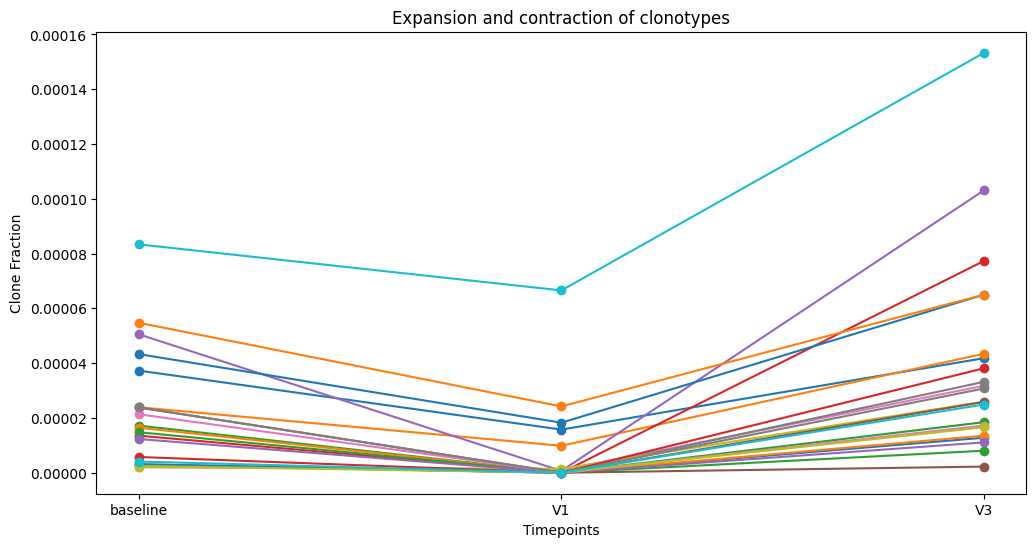

In [200]:
# for each row plot a line that shows the trend of the cloneFraction over time (baseline, V1, V3)
# make subplots for each condition
plt.figure(figsize=(12, 6))
plt.title('Expansion and contraction of clonotypes')
plt.xlabel('Timepoints')
plt.ylabel('Clone Fraction')
for i, row in expansion_contraction.iterrows():
    if row['CONDITION'] == 'Healthy':
        plt.plot([0, 1, 2], [row['baseline'], row['V1'], row['V3']], marker='o', label=row['v_call'])
        plt.xticks([0, 1, 2], ['baseline', 'V1', 'V3'])

### Test specific V gene usage of those samples that cluster together

In [67]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_11', 's_12', 's_13', 's_14', 's_16'],
                    'baseline', '1', PLOTSDIR)

R[write to console]: 
Caricamento pacchetto: ‘reshape2’


R[write to console]: Il seguente oggetto è mascherato da ‘package:tidyr’:

    smiths




array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster1.png'],
      dtype='<U88')

In [68]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_2', 's_3', 's_4', 's_7', 's_8'],
                    'baseline', '2', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster2.png'],
      dtype='<U88')

In [69]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_8', 's_9', 's_12', 's_16'],
                    'V3', '3', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster3.png'],
      dtype='<U88')

In [70]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_11', 's_13', 's_15', 's_17'],
                    'V3', '4', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster4.png'],
      dtype='<U88')

In [71]:
pandas2ri.activate()
ro.r('''
    source('src/utils/plotting.R')
''')
test_cluster_vgenes = ro.globalenv['test_cluster_vgenes']
test_cluster_vgenes(trbv_gene_usage.reset_index(), metadata_test,
                    ['s_2', 's_4', 's_5', 's_7', 's_14'],
                    'V3', '5', PLOTSDIR)

array(['/Users/fabioaffaticati/Desktop/Work/lymphoma_covid/results/plots/Vgene_spec_cluster5.png'],
      dtype='<U88')

### Shannnon diversity

In [72]:
patients, condition, timepoint = [el[0] for el in list(trbv_gene_usage.index)], [el[1] for el in list(trbv_gene_usage.index)], [el[2] for el in list(trbv_gene_usage.index)]
shannon = alpha_diversity('shannon', trbv_gene_usage, patients)
norm_factor = np.log2(len(trbv_gene_usage.columns))
stat = pd.DataFrame({"Shannon_index": shannon,
                        "Condition": condition,
                        "Timepoint": timepoint,})
stat['Shannon_index'] = stat['Shannon_index']/norm_factor
stat['sample_id'] = stat.index
stat.reset_index(inplace=True, drop=True)

In [ ]:
def plot_gene_entropy_comparison(stat, highlight_samples, ylimits, plotname, title, plotsdir):
    
    
    timepoint_colors = {
    "baseline": '#004D40',
    "V1": '#1E88E5',
    "V3": '#FFC107'
    }


    fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Healthy", "Lymphomas"))

    healthy_data = stat.query('Condition == "Healthy"')
    for timepoint in healthy_data["Timepoint"].unique():
        filtered_data = healthy_data[healthy_data["Timepoint"] == timepoint]
        fig.add_trace(
            go.Box(y=filtered_data["Shannon_index"],
                name=timepoint, text=filtered_data["sample_id"], boxpoints = 'all',
                marker=dict(color=timepoint_colors[timepoint], line=dict(width=0.5)),
                showlegend=True),
            row=1, col=1
        )
        
        
    # Filter data to get the highlighted samples
    highlight_data = healthy_data[healthy_data['sample_id'].isin(highlight_samples)]

    # Add highlighted samples as a scatter plot trace
    fig.add_trace(
        go.Scatter(
            x=highlight_data['Timepoint'],
            y=highlight_data['Shannon_index'],
            mode='markers',
            marker=dict(color='red', size=10, symbol='star'),
            name='Already positive individuals',
            text=highlight_data['sample_id'],  # Hover text for highlighted samples
            showlegend=True),
        row=1, col=1
    )
        
    lymphoma_data = stat.query('Condition == "Lymphomas"')
    for timepoint in lymphoma_data["Timepoint"].unique():
        filtered_data = lymphoma_data[lymphoma_data["Timepoint"] == timepoint]
        fig.add_trace(
            go.Box(y=filtered_data["Shannon_index"],
                name=timepoint, text=filtered_data["sample_id"], boxpoints = 'all',
                marker=dict(color=timepoint_colors[timepoint], line=dict(width=0.5)),
                showlegend=False),
            row=1, col=2
        )


    # Filter data to get the highlighted samples
    highlight_data = lymphoma_data[lymphoma_data['sample_id'].isin(highlight_samples)]

    # Add highlighted samples as a scatter plot trace
    fig.add_trace(
        go.Scatter(
            x=highlight_data['Timepoint'],
            y=highlight_data['Shannon_index'],
            mode='markers',
            marker=dict(color='red', size=10, symbol='star'),
            name='Already positive individuals',
            text=highlight_data['sample_id'],  # Hover text for highlighted samples
            showlegend=False),
        row=1, col=2
    )

    fig.update_layout(
        font=dict(family=FONT, size=12),
        #paper_bgcolor='rgb(243, 243, 243)',
        #plot_bgcolor='rgb(243, 243, 243)',
        barmode='group',
        bargap=0.1,
        title_text=title,
        xaxis_title="Condition",
        yaxis_title="Normalised Shannon index",
        legend_title="Timepoints",
        height = 600,
        width = 1000,
        template="plotly_white"
    )


    fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        showgrid=False
    )
    fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        showgrid=True,
        range= ylimits
    )
    fig.write_image(plotsdir + plotname + '.png', scale = 4)
    fig.show()

In [73]:
# Define specific samples to highlight
highlight_samples = ['39700', 'A1', 'A8', '39678', 'A6', 'B1', '7L', '8L', '9L'] 
plotting.plot_gene_entropy_comparison(stat, highlight_samples, [0., .91],
                                       'vgene_usage_covid', 'Comparison of V gene usage Shannon entropies (COVID-19 specific)', PLOTSDIR)

### Using no clonality

In [74]:
trbv_gene_usage = data.query('TCR_Chain == "TRB"')
trbv_gene_usage = trbv_gene_usage[trbv_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]
trbv_gene_usage['count'] = 1
trbv_gene_usage = trbv_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS'], columns='v_call', values='count', fill_value=0, aggfunc='sum')
trbv_gene_usage.head()


,,v_call,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,TRBV12-5,TRBV13,...,TRBV6-5,TRBV6-6,TRBV7-2,TRBV7-3,TRBV7-4,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9
sample_id,CONDITION,TIMEPOINTS,,,,,,,,,,,,,,,,,,,,,
10L,Lymphomas,baseline,0,0,1,0,0,0,1,0,0,0,...,0,1,2,1,0,0,0,1,2,0
11L,Lymphomas,V1,0,0,0,0,0,0,3,0,0,0,...,0,1,3,3,0,0,0,2,7,0
12L,Lymphomas,V3,0,0,1,0,1,0,11,0,0,0,...,1,4,10,2,0,1,1,4,12,4
13L,Lymphomas,baseline,0,0,2,0,0,0,4,0,0,0,...,0,3,12,5,0,0,0,1,10,4
14L,Lymphomas,V1,1,1,5,0,1,0,14,0,2,0,...,4,6,19,10,0,4,3,3,30,8


In [75]:
patients, condition, timepoint = [el[0] for el in list(trbv_gene_usage.index)], [el[1] for el in list(trbv_gene_usage.index)], [el[2] for el in list(trbv_gene_usage.index)]
shannon = alpha_diversity('shannon', trbv_gene_usage, patients)
norm_factor = np.log2(len(trbv_gene_usage.columns))
stat = pd.DataFrame({"Shannon_index": shannon,
                        "Condition": condition,
                        "Timepoint": timepoint,})
stat['Shannon_index'] = stat['Shannon_index']/norm_factor
stat['sample_id'] = stat.index
stat.reset_index(inplace=True, drop=True)

In [76]:
# Define specific samples to highlight
highlight_samples = ['39700', 'A1', 'A8', '39678', 'A6', 'B1', '7L', '8L', '9L']
plotting.plot_gene_entropy_comparison(stat, highlight_samples, [.39, .91],
                                    'vgene_usage_covid_noclonality', 'Comparison of V gene usage Shannon entropies (COVID-19 specific) - no clonality', PLOTSDIR)

## J Gene usage

In [77]:
trbj_gene_usage = data.query('TCR_Chain == "TRB"')
trbj_gene_usage = trbj_gene_usage[trbj_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]
rows_to_remove = trbj_gene_usage.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
trbj_gene_usage = trbj_gene_usage[~trbj_gene_usage.isin(rows_to_remove)].dropna()
trbj_gene_usage = trbj_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS'], columns='j_call', values='cloneFraction', fill_value=0, aggfunc='sum')
trbj_gene_usage.head()


,,j_call,TRBJ1-1,TRBJ1-2,TRBJ1-4,TRBJ1-5,TRBJ1-6,TRBJ2-1,TRBJ2-2,TRBJ2-3,TRBJ2-4,TRBJ2-5,TRBJ2-7
sample_id,CONDITION,TIMEPOINTS,,,,,,,,,,,
10L,Lymphomas,baseline,0.000000,0.000000,0.000000,0.000000,0.000014,0.000038,0.000208,0.000022,0.000000,0.000062,0.000029
11L,Lymphomas,V1,0.000006,0.000029,0.000000,0.000000,0.000005,0.000123,0.000361,0.000013,0.000000,0.000000,0.000048
12L,Lymphomas,V3,0.000003,0.000015,0.000006,0.000000,0.000001,0.000067,0.000584,0.000020,0.000001,0.000007,0.000028
13L,Lymphomas,baseline,0.000005,0.000007,0.000011,0.000001,0.000060,0.000022,0.000667,0.000041,0.000000,0.000165,0.000064
14L,Lymphomas,V1,0.000019,0.000027,0.000000,0.000002,0.000037,0.000027,0.000642,0.000017,0.000001,0.000211,0.000058


In [78]:
patients, condition, timepoint = [el[0] for el in list(trbj_gene_usage.index)], [el[1] for el in list(trbj_gene_usage.index)], [el[2] for el in list(trbj_gene_usage.index)]
shannon = alpha_diversity('shannon', trbj_gene_usage, patients)
norm_factor = np.log2(len(trbj_gene_usage.columns))
stat = pd.DataFrame({"Shannon_index": shannon,
                        "Condition": condition,
                        "Timepoint": timepoint,})
stat['Shannon_index'] = stat['Shannon_index']/norm_factor
stat['sample_id'] = stat.index
stat.reset_index(inplace=True, drop=True)

In [79]:
# Define specific samples to highlight
highlight_samples = ['39700', 'A1', 'A8', '39678', 'A6', 'B1', '7L', '8L', '9L']
plotting.plot_gene_entropy_comparison(stat, highlight_samples, [-0.01, .71],
                                    'jgene_usage_covid', 'Comparison of J gene usage Shannon entropies (COVID-19 specific)', PLOTSDIR)

## Entropy testing

In [80]:
pairs=[("Healthy", "Lymphomas")]
trbv_gene_usage = data.query('TCR_Chain == "TRB"')
trbv_gene_usage = trbv_gene_usage.query('SAMPLE != "s_1" and SAMPLE != "s_10"')
rows_to_remove = trbv_gene_usage.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
trbv_gene_usage = trbv_gene_usage[~trbv_gene_usage.isin(rows_to_remove)].dropna()
trbv_gene_usage = trbv_gene_usage[trbv_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]

In [81]:
pivoted = trbv_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], columns='v_call', values='cloneFraction', fill_value=0, aggfunc='sum')

for timepoint in metadata['TIMEPOINTS'].unique():
    filtered_data = pivoted[pivoted.index.get_level_values('TIMEPOINTS') == timepoint]
    plotting.alpha_diversity_tcr(filtered_data, pairs, PLOTSDIR, timepoint + ' V gene')

In [82]:
pivoted = trbv_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS'], columns='clonotype', values='cloneFraction', fill_value=0, aggfunc='sum')

for timepoint in metadata['TIMEPOINTS'].unique():
    filtered_data = pivoted[pivoted.index.get_level_values('TIMEPOINTS') == timepoint]
    plotting.alpha_diversity_tcr(filtered_data, pairs, PLOTSDIR, timepoint+ ' clonotype')

## Single gene usage and testing

### Gene entropies

In [83]:
specific = data.query('TCR_Chain == "TRB"')
specific = specific[specific['clonotype'].isin(DETECT_predictions['clonotype'])]

rows_to_remove = specific.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
specific = specific[~specific.isin(rows_to_remove)].dropna()

ventropies = []
pivoted = specific.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'],
            columns='clonotype', values='cloneFraction', fill_value=0, aggfunc='sum')

for vgene in specific['v_call'].unique():
    # keep only columns that start with "vgene"``
    filtered = pivoted[pivoted.columns[pivoted.columns.str.startswith(vgene)]]
    stat = pd.DataFrame()
    stat['Shannon_index'] = alpha_diversity('shannon', filtered, filtered.index.get_level_values('sample_id'))
    norm_factor = np.log2(len(filtered.columns))
    stat['Normalised_Shannon_entropy'] = stat['Shannon_index']/norm_factor
    stat['v_call'] = vgene
    ventropies.append(stat)
    
ventropies = pd.concat(ventropies)
ventropies.reset_index(inplace=True)
ventropies.shape

(2295, 4)

In [84]:
ventropies.head()

,sample_id,Shannon_index,Normalised_Shannon_entropy,v_call
0,10L,0.0,0.0,TRBV10-1
1,11L,0.0,0.0,TRBV10-1
2,12L,0.0,0.0,TRBV10-1
3,13L,0.0,0.0,TRBV10-1
4,14L,0.0,0.0,TRBV10-1


### Clonal fraction

In [85]:
long_df_gene_usage = data.query('TCR_Chain == "TRB"')
long_df_gene_usage = long_df_gene_usage[long_df_gene_usage['clonotype'].isin(DETECT_predictions['clonotype'])]

rows_to_remove = long_df_gene_usage.query('v_call == "TRBV15" and j_call == "TRBJ2-2" and junction_aa == "CATSLANTGELFF" and SAMPLE == "s_9"')
long_df_gene_usage = specific[~long_df_gene_usage.isin(rows_to_remove)].dropna()

long_df_gene_usage = long_df_gene_usage.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], columns='v_call', values='cloneFraction', fill_value=0, aggfunc='sum')

long_df_gene_usage = pd.melt(long_df_gene_usage.reset_index(), id_vars=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'],
                             value_vars=long_df_gene_usage.columns,var_name='v_call', value_name='cloneFraction')
long_df_gene_usage.reset_index(drop=True, inplace=True)
long_df_gene_usage

,sample_id,CONDITION,TIMEPOINTS,SAMPLE,v_call,cloneFraction
0,10L,Lymphomas,baseline,s_11,TRBV10-1,0.000000
1,11L,Lymphomas,V1,s_11,TRBV10-1,0.000000
2,12L,Lymphomas,V3,s_11,TRBV10-1,0.000000
3,13L,Lymphomas,baseline,s_12,TRBV10-1,0.000000
4,14L,Lymphomas,V1,s_12,TRBV10-1,0.000003
...,...,...,...,...,...,...
2290,A7,Healthy,V1,s_7,TRBV9,0.000000
2291,A8,Healthy,V3,s_1,TRBV9,0.000004
2292,A9,Healthy,V3,s_2,TRBV9,0.000011
2293,B1,Healthy,V3,s_6,TRBV9,0.000015


### Number of unique clonotypes

In [86]:
unique_counts = data.query('TCR_Chain == "TRB"')
unique_counts = unique_counts[unique_counts['clonotype'].isin(DETECT_predictions['clonotype'])]
unique_counts['unique_counts'] = 1
unique_counts = unique_counts.pivot_table(index=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'],
                                          columns='v_call', values='unique_counts', fill_value=0, aggfunc='sum')
unique_counts = pd.melt(unique_counts.reset_index(), id_vars=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'],
                             value_vars=unique_counts.columns,var_name='v_call', value_name='unique_counts')
unique_counts.reset_index(drop=True, inplace=True)
unique_counts

,sample_id,CONDITION,TIMEPOINTS,SAMPLE,v_call,unique_counts
0,10L,Lymphomas,baseline,s_11,TRBV10-1,0
1,11L,Lymphomas,V1,s_11,TRBV10-1,0
2,12L,Lymphomas,V3,s_11,TRBV10-1,0
3,13L,Lymphomas,baseline,s_12,TRBV10-1,0
4,14L,Lymphomas,V1,s_12,TRBV10-1,1
...,...,...,...,...,...,...
2290,A7,Healthy,V1,s_7,TRBV9,0
2291,A8,Healthy,V3,s_1,TRBV9,2
2292,A9,Healthy,V3,s_2,TRBV9,2
2293,B1,Healthy,V3,s_6,TRBV9,3


### Merge

In [87]:
gene_usage = pd.merge(long_df_gene_usage, unique_counts, on=['sample_id','v_call','CONDITION','TIMEPOINTS','SAMPLE'])
gene_usage = pd.merge(gene_usage, ventropies, on=['sample_id', 'v_call'])
gene_usage = pd.merge(gene_usage, library_size, on='sample_id', how='left')
gene_usage = gene_usage.query('SAMPLE != "s_1" and SAMPLE != "s_10"')
gene_usage = gene_usage.sort_values(by=['SAMPLE', 'TIMEPOINTS', 'v_call'], ascending=[True, False, True])

gene_usage['normalizedUniqueCounts'] = gene_usage['unique_counts']/gene_usage['cloneCount']

# fill missing values with 0
gene_usage.fillna(0, inplace=True)

In [88]:
gene_usage = pd.merge(gene_usage, metadata, on=['sample_id', 'CONDITION', 'TIMEPOINTS', 'SAMPLE'], how='left')

### Plotting

In [89]:
variables_to_test = ['cloneFraction', 'unique_counts', 'Normalised_Shannon_entropy', 'normalizedUniqueCounts']
plotting.testing_and_plot_singlegene_usage(gene_usage, variables_to_test, PLOTSDIR)

Tested varialbe: cloneFraction
TRBV10-1 at baseline has a non-significant adjusted p-value of 0.8287564156477486
TRBV10-2 at baseline has a non-significant adjusted p-value of 1.0
TRBV10-3 at baseline has a non-significant adjusted p-value of 1.0
TRBV11-1 at baseline has a non-significant adjusted p-value of 1.0
TRBV11-2 at baseline has a non-significant adjusted p-value of 0.3539102091013431
TRBV11-3 at baseline has a non-significant adjusted p-value of 0.8932364539996732
TRBV12-3 at baseline has a non-significant adjusted p-value of 0.6316146174074653
TRBV12-4 at baseline has a non-significant adjusted p-value of 0.8287564156477486
TRBV12-5 at baseline has a non-significant adjusted p-value of 0.3539102091013431
TRBV13 at baseline has a non-significant adjusted p-value of 0.8287564156477486
TRBV14 at baseline has a non-significant adjusted p-value of 1.0
TRBV15 at baseline has a non-significant adjusted p-value of 1.0
TRBV18 at baseline has a non-significant adjusted p-value of 0.653

## Additional

In [75]:
# Function to calculate Spearman correlation
def calc_spearman(df, x, y):
    corr, pval = spearmanr(list(df[x]), list(df[y]))
    return pd.Series({'Spearman_corr': corr, 'p_value': pval})

# Function to calculate Pearson correlation
def calc_pearson(df, x, y):
    corr, pval = pearsonr(list(df[x]), list(df[y]))
    return pd.Series({'Pearson_corr': corr, 'p_value': pval})

In [76]:
correlation_results = gene_usage.groupby(['TIMEPOINTS', 'CONDITION']).apply(lambda df: calc_spearman(df, 'Shannon_index', 'unique_counts'))
correlation_results.reset_index(inplace=True)
correlation_results['TIMEPOINTS'] = pd.Categorical(correlation_results['TIMEPOINTS'], ["baseline", "V1", "V3"])
correlation_results['CONDITION'] = pd.Categorical(correlation_results['CONDITION'], ["Healthy", "Lymphomas"])
correlation_results.sort_values(by=['CONDITION', 'TIMEPOINTS'], ascending=[True, True], inplace=True)
correlation_results

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_51076/3396499673.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,TIMEPOINTS,CONDITION,Spearman_corr,p_value
4,baseline,Healthy,0.879984,1.251148e-88
0,V1,Healthy,0.879393,2.316917e-88
2,V3,Healthy,0.840323,3.109458e-73
5,baseline,Lymphomas,0.798718,6.136657e-91
1,V1,Lymphomas,0.871595,7.728552e-127
3,V3,Lymphomas,0.876935,2.617132e-130


In [77]:
gene_usage['TIMEPOINTS'] = pd.Categorical(gene_usage['TIMEPOINTS'], ["baseline", "V1", "V3"])
gene_usage['CONDITION'] = pd.Categorical(gene_usage['CONDITION'], ["Healthy", "Lymphomas"])

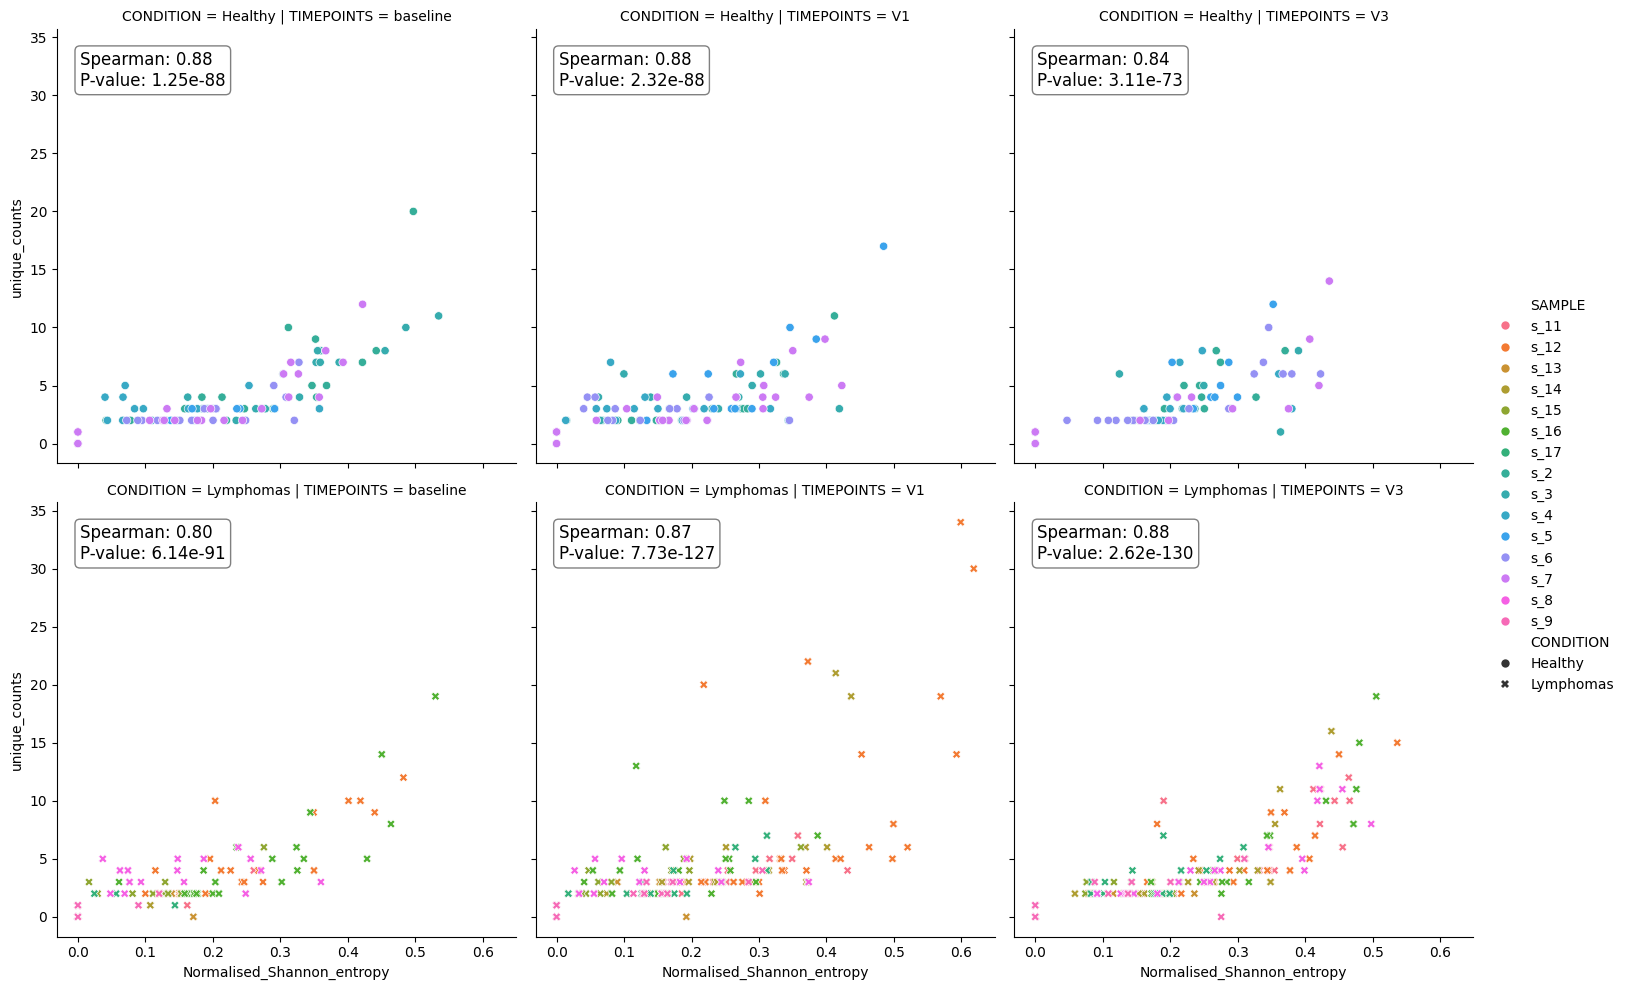

In [78]:
g = sns.relplot(x='Normalised_Shannon_entropy', y='unique_counts', data=gene_usage, hue='SAMPLE',
                style='CONDITION', col="TIMEPOINTS", row="CONDITION")

# Annotate each subplot with the corresponding Spearman correlation
for ax, (timepoint, condition) in zip(g.axes.flat, correlation_results[['TIMEPOINTS', 'CONDITION']].itertuples(index=False)):
    # Get the correlation value for the current subplot
    corr_value = correlation_results[(correlation_results['TIMEPOINTS'] == timepoint) & (correlation_results['CONDITION'] == condition)]['Spearman_corr'].values[0]
    
    p_value = correlation_results[(correlation_results['TIMEPOINTS'] == timepoint) & (correlation_results['CONDITION'] == condition)]['p_value'].values[0]
    
    
    # Format the annotation text
    annotation = f'Spearman: {corr_value:.2f}\nP-value: {p_value:.2e}'
    
    # Annotate the plot with the correlation value and p-value
    ax.text(0.05, 0.95, annotation, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white'))



# Show the plot
plt.show()

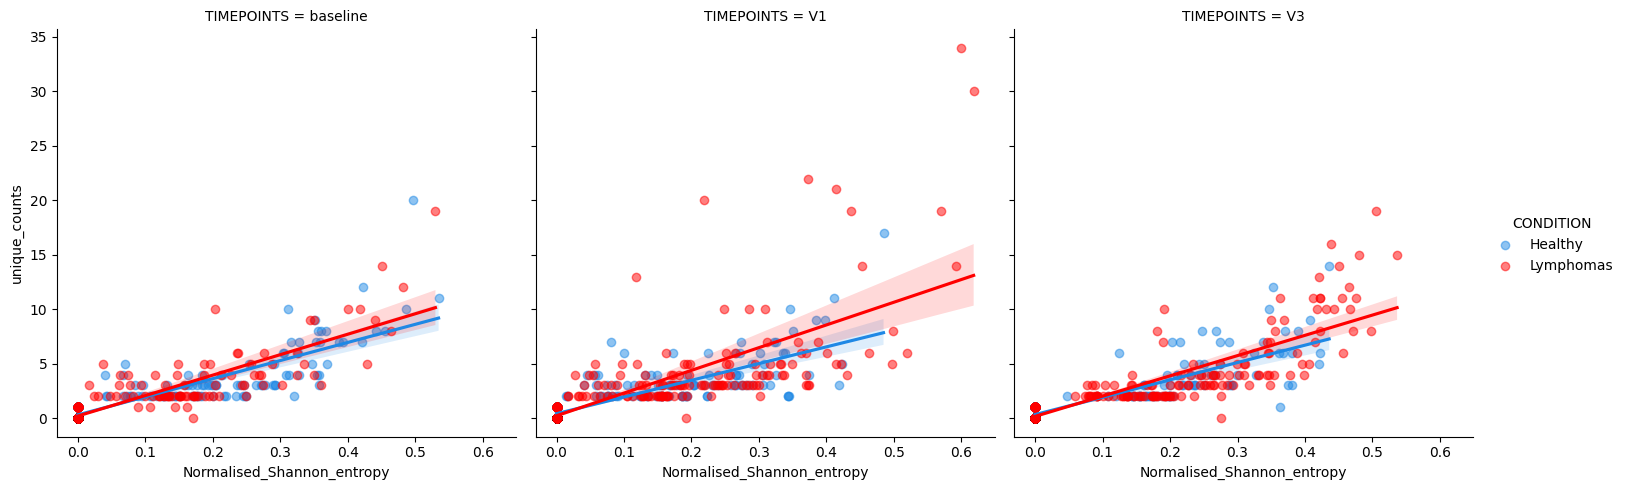

In [79]:
sns.lmplot(data=gene_usage, x="Normalised_Shannon_entropy", y="unique_counts", hue="CONDITION", col ="TIMEPOINTS",
           hue_order = ['Healthy', 'Lymphomas'], palette = ['#1E88E5', 'red'], scatter_kws={'alpha':0.5})

In [80]:
correlation_results = gene_usage.groupby(['TIMEPOINTS', 'CONDITION']).apply(lambda df: calc_pearson(df, 'cloneFraction', 'unique_counts'))
correlation_results.reset_index(inplace=True)
correlation_results['TIMEPOINTS'] = pd.Categorical(correlation_results['TIMEPOINTS'], ["baseline", "V1", "V3"])
correlation_results['CONDITION'] = pd.Categorical(correlation_results['CONDITION'], ["Healthy", "Lymphomas"])
correlation_results.sort_values(by=['CONDITION', 'TIMEPOINTS'], ascending=[True, True], inplace=True)
correlation_results

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_51076/293074264.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/br/mxlpyjk52nz_ksh4b5vpy4340000gn/T/ipykernel_51076/293074264.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,TIMEPOINTS,CONDITION,Pearson_corr,p_value
0,baseline,Healthy,0.623384,1.807356e-30
2,V1,Healthy,0.709072,1.487132e-42
4,V3,Healthy,0.672493,6.733109e-37
1,baseline,Lymphomas,0.460097,1.308481e-22
3,V1,Lymphomas,0.471230,8.871416e-24
5,V3,Lymphomas,0.607346,3.450033e-42


In [81]:
gene_usage = gene_usage.query('SAMPLE != "s_9"')

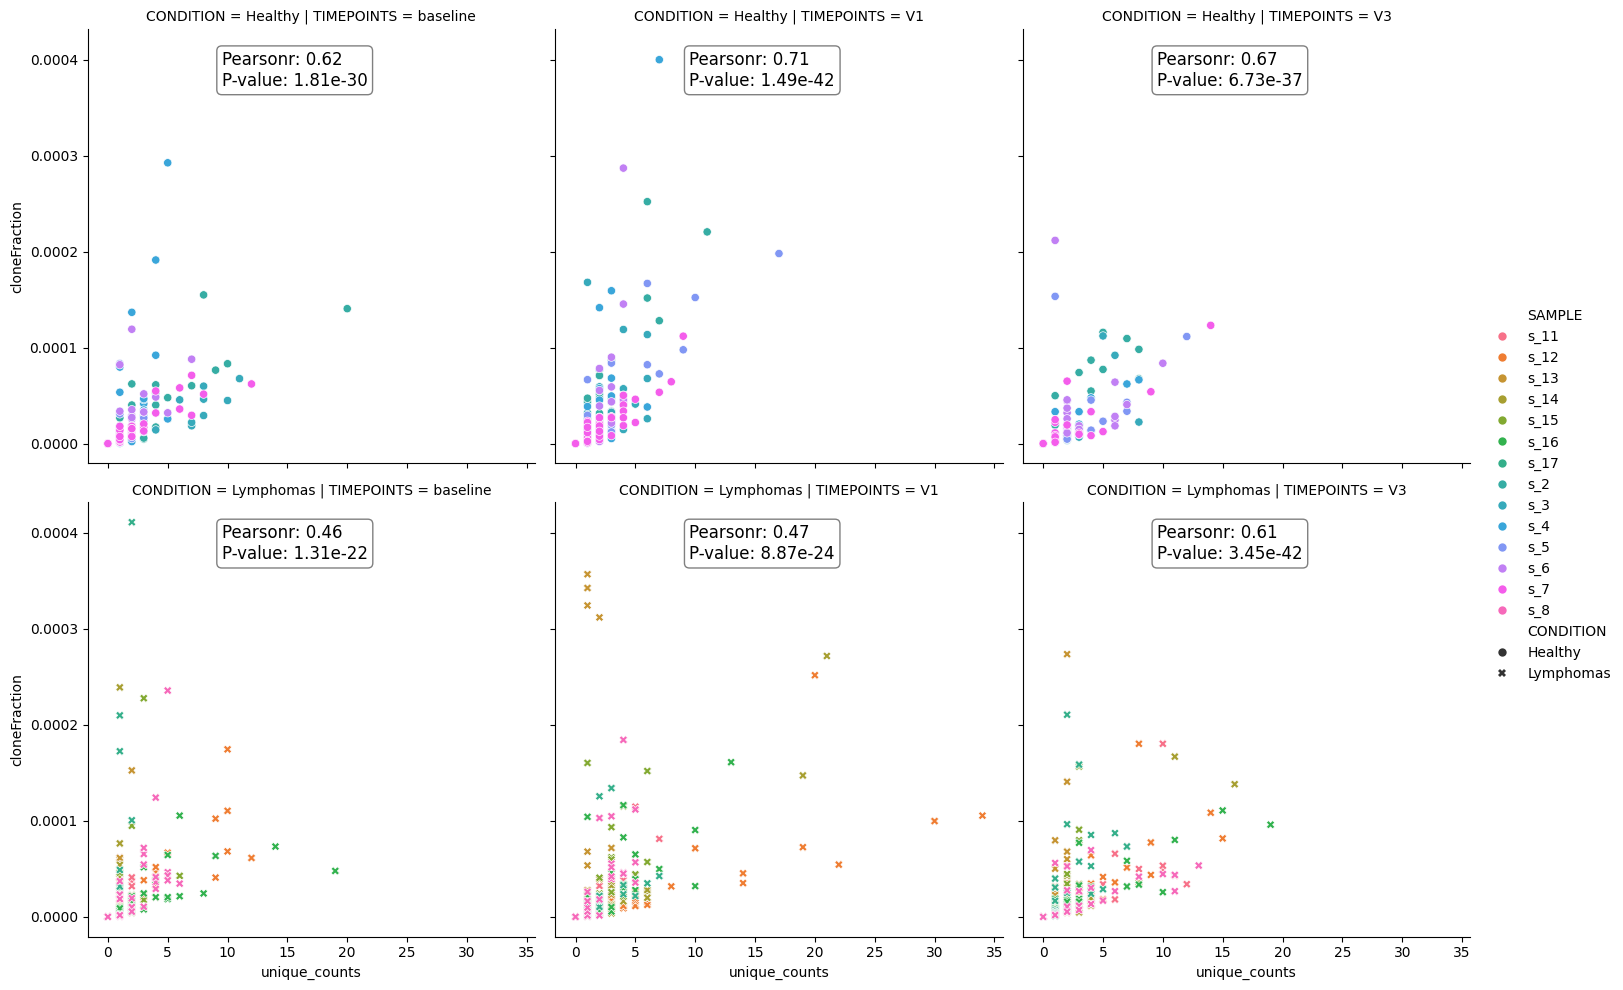

In [82]:
g = sns.relplot(x='unique_counts', y='cloneFraction', data=gene_usage, hue='SAMPLE',
                style='CONDITION', col="TIMEPOINTS", row="CONDITION")
#for ax in g.axes.flatten():
#    ax.set_yscale('log')
# Annotate each subplot with the corresponding Spearman correlation
for ax, (timepoint, condition) in zip(g.axes.flat, correlation_results[['TIMEPOINTS', 'CONDITION']].itertuples(index=False)):
    # Get the correlation value for the current subplot
    corr_value = correlation_results[(correlation_results['TIMEPOINTS'] == timepoint) & (correlation_results['CONDITION'] == condition)]['Pearson_corr'].values[0]
    
    p_value = correlation_results[(correlation_results['TIMEPOINTS'] == timepoint) & (correlation_results['CONDITION'] == condition)]['p_value'].values[0]
    
    
    # Format the annotation text
    annotation = f'Pearsonr: {corr_value:.2f}\nP-value: {p_value:.2e}'
    
    # Annotate the plot with the correlation value and p-value
    ax.text(0.3, 0.95, annotation, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white'))



# Show the plot
plt.show()

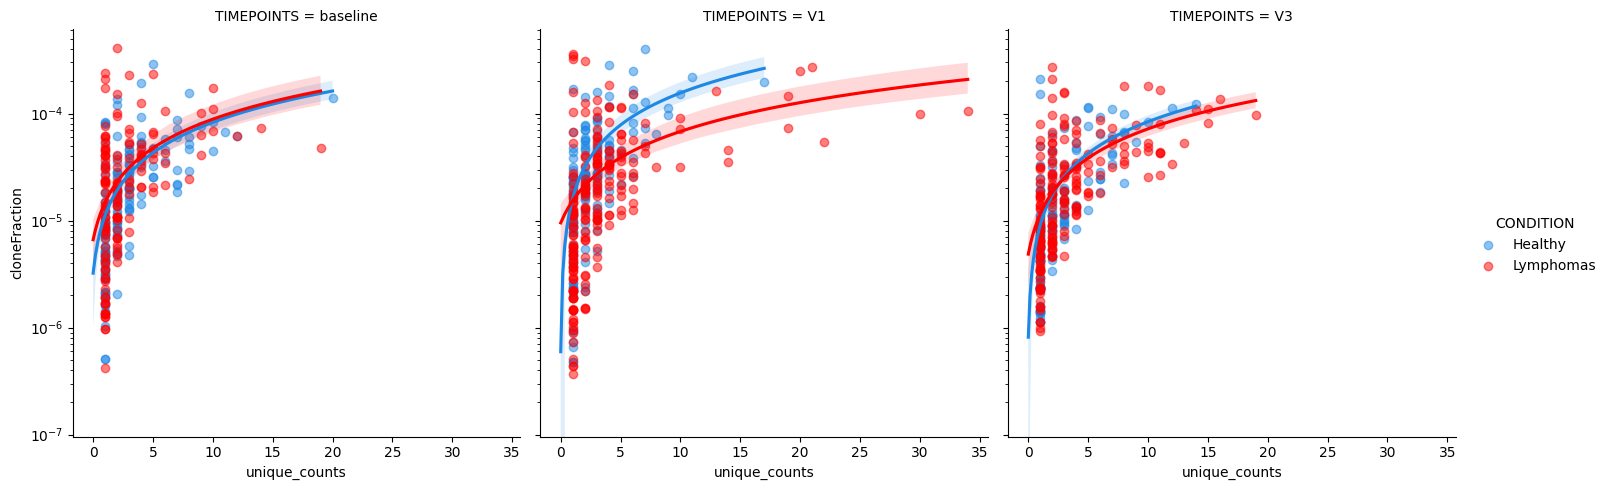

In [83]:
import seaborn as sns

g = sns.lmplot(data=gene_usage, x="unique_counts", y="cloneFraction", hue="CONDITION", col ="TIMEPOINTS",
           hue_order = ['Healthy', 'Lymphomas'], palette = ['#1E88E5', 'red'], scatter_kws={'alpha':0.5})
for ax in g.axes.flatten():
    ax.set_yscale('log')

In [84]:
def bland_altman_plot(data1, data2, v_call, condition, mean_healthy, mean_lymphomas,
                      annotation_text, color_mapping, plot_size=(800, 600)):
    
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    # Create a scatter plot with Plotly
    fig = go.Figure()

    # Add scatter plot points
    fig.add_trace(go.Scatter(
        x=mean, 
        y=diff,
        mode='markers',
        marker=dict(color=condition, size=6),
        text=v_call,  # This is the hover text
        showlegend=False,
        hovertemplate='V_call: %{text}<br>Mean: %{x}<br>Difference: %{y}<extra></extra>'
    ))

    # Add horizontal lines for mean and 1.96*SD
    fig.add_hline(y=md, line=dict(color='green', dash='dash'), name='Mean Difference')
    fig.add_hline(y=mean_healthy, line=dict(color='blue', dash='dash'), name='Mean diff Healthy')
    fig.add_hline(y=mean_lymphomas, line=dict(color='red', dash='dash'), name='Mean diff Lymphomas')
    fig.add_hline(y=md + 1.96*sd, line=dict(color='gray', dash='dash'), name='+1.96 SD')
    fig.add_hline(y=md - 1.96*sd, line=dict(color='gray', dash='dash'), name='-1.96 SD')
    
    # Annotate the horizontal lines
    fig.add_annotation(x=mean.max(), y=md, text='Mean Difference', showarrow=False, yshift=10, font=dict(color='green'))
    fig.add_annotation(x=mean.max(), y=mean_healthy, text='Mean diff Healthy', showarrow=False, yshift=30, font=dict(color='blue'))
    fig.add_annotation(x=mean.max(), y=mean_lymphomas, text='Mean diff Lymphomas', showarrow=False, yshift=-25, font=dict(color='red'))
    fig.add_annotation(x=mean.max(), y=md + 1.96*sd, text='+1.96 SD', showarrow=False, yshift=10, font=dict(color='gray'))
    fig.add_annotation(x=mean.max(), y=md - 1.96*sd, text='-1.96 SD', showarrow=False, yshift=-10, font=dict(color='gray'))


    # Update layout
    fig.update_layout(
        font=dict(family=FONT, size=12),
        #paper_bgcolor='rgb(243, 243, 243)',
        #plot_bgcolor='rgb(243, 243, 243)',
        barmode='group',
        title='Bland-Altman Plot',
        width=plot_size[0],
        height=plot_size[1],
        bargap=0.1,
        xaxis_title='Mean of clonal fraction per V gene between V3 and V1',
        yaxis_title='Difference between V3 and V1',
        legend_title="Conditions",
        template="plotly_white"
    )
    # Map condition to colors and add to legend
    for cond in color_mapping.keys():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], 
            mode='markers',
            marker=dict(size=10, color=color_mapping[cond]),
            legendgroup=cond,
            showlegend=True,
            name=cond
        ))

    # add annotation text
    fig.add_annotation(
        x=0.5, y=1.05,
        xref='paper', yref='paper',
        text='Two-sided t-test L vs H: t-statistic {:.3f} p-value {:.3f}'.format(annotation_text[0], annotation_text[1]),
        showarrow=False,)
    fig.write_image(PLOTSDIR + 'altman.png', scale = 4)
    fig.show()
    
    
    
    
    
condition = gene_usage.query('TIMEPOINTS == "V1"')['CONDITION']
v_call = gene_usage.query('TIMEPOINTS == "V1"')['v_call']

color_mapping = {'Healthy': 'blue', 'Lymphomas': 'red'}
# Replace conditions with colors
condition = condition.map(color_mapping)



#diff = np.array(gene_usage.query('TIMEPOINTS == "V3"')['Normalised_Shannon_entropy']) - np.array(gene_usage.query('TIMEPOINTS == "V1"')['Normalised_Shannon_entropy'])

diff = np.array(gene_usage.query('TIMEPOINTS == "V3"')['cloneFraction']) - np.array(gene_usage.query('TIMEPOINTS == "V1"')['cloneFraction'])

diff = pd.DataFrame(diff, columns=['Difference'])
diff.reset_index(drop=True, inplace=True)
diff['Sample'] = list(gene_usage.query('TIMEPOINTS == "V3"')['sample_id'])
diff['Condition'] = list(gene_usage.query('TIMEPOINTS == "V3"')['CONDITION'])


ttest = ttest_ind(np.array(diff.query('Condition == "Lymphomas"')['Difference']),
                np.array(diff.query('Condition == "Healthy"')['Difference']), equal_var=False, permutations = 1000, alternative = 'two-sided', random_state = 42)
mean_lymphomas = np.mean(np.array(diff.query('Condition == "Lymphomas"')['Difference']), axis=0)
mean_healthy = np.mean(np.array(diff.query('Condition == "Healthy"')['Difference']), axis=0)

bland_altman_plot(      
                        np.array(gene_usage.query('TIMEPOINTS == "V3"')['cloneFraction']),
                        np.array(gene_usage.query('TIMEPOINTS == "V1"')['cloneFraction']),
                        #np.array(gene_usage.query('TIMEPOINTS == "V3"')['Normalised_Shannon_entropy']),
                        #np.array(gene_usage.query('TIMEPOINTS == "V1"')['Normalised_Shannon_entropy']),
                        v_call,
                        condition,
                        mean_healthy,
                        mean_lymphomas,
                        ttest,
                        color_mapping)




In [ ]:
clonal_breadth_data = clonal_breadth_data.query('TIMEPOINTS == "V1"')
clonal_breadth_data = pd.merge(clonal_breadth_data, combined_predictions[['SAMPLE', 'match', 'locus']], on=['SAMPLE'])
clonal_breadth_data.head()

In [ ]:
colors = {'Healthy': 'blue', 'Lymphomas': 'red'}


for locus in clonal_breadth_data['locus'].unique():
    fig = go.Figure()
    for condition in clonal_breadth_data['CONDITION'].unique():
        
        aux = clonal_breadth_data.query('CONDITION == @condition and locus == @locus')
        fig.add_trace(go.Box(y=aux['fraction_sequences'], x=aux['match'],
                            name=condition,
                            hovertext = aux['sample_id'],
                            boxpoints='all',
                            marker = dict(color=colors[condition]),
                            jitter=0.3, ))

        fig.update_layout(boxmode='group')

            
    fig.update_layout(font=dict(
            size=14,
            family=FONT,
        ),
        height=500,
        width=700,
        legend_title= 'Condition',
        xaxis_title='HLA alleles',
        yaxis_title='Covid Specific fraction of sequences (breadth)',
        template='plotly_white',
    )
    fig.update_xaxes(tickangle=45, tickmode='array', showgrid = True)
    fig.update_yaxes(range=[min(aux['fraction_sequences'])-0.0005, max(aux['fraction_sequences'])+0.0005])
    fig.write_image(PLOTSDIR+locus+"_breadth.png", scale = 4)

In [ ]:
clonal_breadth_data = clonal_breadth_data.groupby(['sample_id', 'SAMPLE',
                                    'TIMEPOINTS', 'CONDITION'],
                                   as_index=False).agg({'fraction_sequences': 'first', 'match': ','.join})

In [ ]:
fig = go.Figure()
for condition in clonal_breadth_data['CONDITION'].unique():
    
    aux = clonal_breadth_data.query('CONDITION == @condition')
    fig.add_trace(go.Box(y=aux['fraction_sequences'], x=aux['match'],
                        name=condition,
                        hovertext = aux['sample_id'],
                        boxpoints='all',
                        marker = dict(color=colors[condition]),
                        jitter=0.3, ))

    fig.update_layout(boxmode='group')

        
fig.update_layout(font=dict(
        size=14,
        family=FONT,
    ),
    height=700,
    width=1000,
    legend_title= 'Condition',
    xaxis_title='HLA alleles',
    yaxis_title='Covid Specific fraction of sequences (breadth)',
    template='plotly_white',
)
fig.update_xaxes(tickangle=45, tickmode='array', showgrid = True)
fig.update_yaxes(range=[0.0008, 0.0019])
fig.write_image(PLOTSDIR+"HLA_combo_breadth.png", scale = 2)

In [ ]:
clonal_depth_data = clonal_depth_data.query('TIMEPOINTS == "V1"')
clonal_depth_data = pd.merge(clonal_depth_data, combined_predictions[['SAMPLE', 'match', 'locus']], on=['SAMPLE'])

In [ ]:
for locus in clonal_depth_data['locus'].unique():
    fig = go.Figure()
    for condition in clonal_depth_data['CONDITION'].unique():
        
        aux = clonal_depth_data.query('CONDITION == @condition and locus == @locus')
        fig.add_trace(go.Box(y=aux['cloneFraction'], x=aux['match'],
                            name=condition,
                            hovertext = aux['sample_id'],
                            boxpoints='all',
                            marker = dict(color=colors[condition]),
                            jitter=0.3, ))

        fig.update_layout(boxmode='group')

            
    fig.update_layout(font=dict(
            size=14,
            family=FONT,
        ),
        height=500,
        width=700,
        legend_title= 'Condition',
        xaxis_title='HLA alleles',
        yaxis_title='Covid Specific clonal fraction (depth)',
        template='plotly_white',
    )
    fig.update_xaxes(tickangle=45, tickmode='array', showgrid = True)
    fig.update_yaxes(range=[min(aux['cloneFraction'])-0.0005, max(aux['cloneFraction'])+0.0005])
    fig.write_image(PLOTSDIR+locus+"_depth.png", scale = 4)